In [1]:
import os
import sys
import time
import yaml
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.constants import c
from lib.formulary import BunchLength, ion_BunchLength, EnergySpread
from lib.loadlattice import prepareTwiss
from lib.IBSfunctions import NagaitsevIBS
from lib.separatrix import def_separatrix, is_in_separtrx

from blond.beam.beam import Beam, Proton
from blond.input_parameters.ring import Ring
from blond.monitors.monitors import BunchMonitor
from blond.input_parameters.rf_parameters import RFStation
from blond.beam.profile import CutOptions, FitOptions, Profile
from blond.trackers.tracker import RingAndRFTracker, FullRingAndRF
from blond.beam.distributions import bigaussian, matched_from_distribution_function

### LHC Parameters

In [2]:
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# !~~~~~~~~~~~~ Bunch parameters ~~~~~~~~~~~! #
N_b = config['bunch_intensity'] # Number of particles; [1]
N_p = int(config['n_mparts'])   # Number of macro-particles; [1]
tau_0 = config['tau']           # 4 sigma bunch length, 4 sigma [s]

# !~~~~~~~ Machine and RF parameters ~~~~~~~! #
C = 26658.883                       # Machine circumference [m]
p = config['energy'] * 1e9      # Synchronous momentum [eV/c]
h = config['h']                 # Harmonic number
phi = 0.                        # RF synchronous phase
Vrf = config['V0max'] * 1e9     # RF voltage [V]

gamma_t = 53.8                  # Transition gamma
alpha   = 1 / gamma_t**2        # First order mom. comp. factor

# !~~~~~~~~~~~~ Tracking details ~~~~~~~~~~~! #
N_t    = int(1e6)#config['N_turns']) # Number of turns to track
N_ibs  = int(config['IBS_stp']) # Number of turns to update IBS
N_mtch = 5000                  # Number of turns for matching
dt_plt = 50

print(f'Circumference: {C} [m],\nHarmonic number: {h}, \nVrf: {Vrf} [V], \ngamma transition: {gamma_t}, \nmomentum compaction factor: {alpha}\n')
print(f'Bunch intensity: {N_b} electrons,\nNumber of macroparticles: {N_p}, \nBunch length: {tau_0} ns, \nEnergy: {p * 1e-9} [GeV]')

Circumference: 26658.883 [m],
Harmonic number: 35640.0, 
Vrf: 5000000.0 [V], 
gamma transition: 53.8, 
momentum compaction factor: 0.000345489973880958

Bunch intensity: 1.6e11 electrons,
Number of macroparticles: 100000, 
Bunch length: 1.2e-09 ns, 
Energy: 450.0 [GeV]


### Simulation Setup

Working directory is /Users/michalis/Work/Fellow/IBS_BLonD/LHC
Ring initialized...
RF station initialized...
Intensity = 1.60e+11 ppb
4sigma bunch length requested = 1.2e-09 [s]
4sigma bunch length from profile = 1.2039789739596e-09 [s]
4sigma bunch length from np.std = 1.2038658986389428e-09 s
Energy spread = 0.0002810601579288284
Turn = 1000
Turn = 2000
Turn = 3000
Turn = 4000
Turn = 5000
Intensity = 1.57e+11 ppb
4sigma bunch length requested = 1.2e-09 [s]
4sigma bunch length from profile = 1.2580452326935437e-09 [s]
4sigma bunch length from np.std = 1.254873119973835e-09 s
Energy spread = 0.0002550179461940448


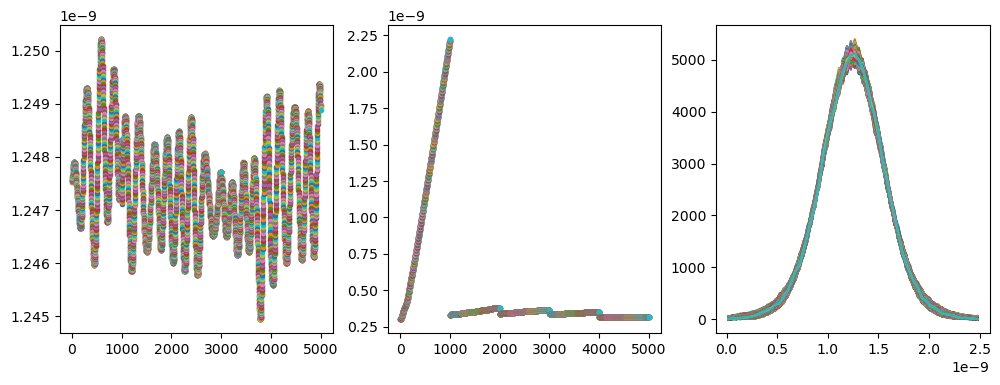

In [3]:
wrkDir = os.getcwd()
print(f"Working directory is {wrkDir}")
if not os.path.isdir(os.path.join(wrkDir,'output')):
    os.mkdir("output")
    print(f"Created output folder {os.path.join(wrkDir,'output')}")

# !~~~~~~~ Define General Parameters ~~~~~~~! #
ring = Ring(C, alpha, p, Proton(), N_t + N_mtch)
print("Ring initialized...")

# !~~~~~~ Define RF Station Parameters ~~~~~! #
rf = RFStation(ring, [h], [Vrf], [phi])
print("RF station initialized...")


# !~~~~~~ Define beam and distribution ~~~~~! #
beam = Beam(ring, N_p, N_b)

n_slices = 64
profile = Profile(beam, CutOptions(n_slices = n_slices, cut_left=0, 
                    cut_right=rf.t_rf[0, 0]), 
                    FitOptions=FitOptions(fit_option='rms'))

# !~~~~~~~~~~~~ Define Separatrix ~~~~~~~~~~! #
Hsep = def_separatrix(ring, rf, beam)

# !~~~~~~~~~~~~~~~~ Trackers ~~~~~~~~~~~~~~~! #
rf_station_tracker = RingAndRFTracker(rf, beam, Profile=profile)
tracker = FullRingAndRF([rf_station_tracker])


# !~~~~~~~~~~~~~~~~ Matching ~~~~~~~~~~~~~~! #
# matched_from_distribution_function(beam, tracker,
#     distribution_type = 'gaussian', bunch_length = tau_0,
#     distribution_variable = 'Hamiltonian', bunch_length_fit = 'gaussian', 
#     n_iterations= 10)

# matched_from_distribution_function(beam, tracker,
#     distribution_type = 'binomial', bunch_length = tau_0, distribution_exponent = 2,
#     distribution_variable = 'Hamiltonian', bunch_length_fit = 'gaussian', 
#     n_iterations= 10)

bigaussian(ring, rf, beam, tau_0 /4.)#, sigma_dE = 0.00030269446429489555 * beam.energy, seed = 41)

profile.track()

print(f'Intensity = {beam.ratio * beam.n_macroparticles_alive:.2e} ppb')
print(f'4sigma bunch length requested = {tau_0} [s]')
print(f'4sigma bunch length from profile = {profile.bunchLength} [s]')
print(f'4sigma bunch length from np.std = {np.std(beam.dt[beam.id > 0]) * 4} s')
print(f'Energy spread = {np.std(beam.dE[beam.id > 0])/beam.energy}')

f, ax = plt.subplots(1, 3, figsize = (12,4))
for turn in range(1, N_mtch+1):

    ax[0].plot(turn, np.mean(beam.dt[beam.id > 0]), '.')
    ax[1].plot(turn, np.std(beam.dt[beam.id > 0]), '.')
    ax[2].plot(profile.bin_centers, profile.n_macroparticles)
    
    if turn % 1000 == 0: 
        print(f'Turn = {turn}')
        lost_index = is_in_separtrx(ring, rf, beam, Hsep)
        beam.id[lost_index] = 0
   
   # Track
    tracker.track()
    profile.track()

print(f'Intensity = {beam.ratio * beam.n_macroparticles_alive:.2e} ppb')
print(f'4sigma bunch length requested = {tau_0} [s]')
print(f'4sigma bunch length from profile = {profile.bunchLength} [s]')
print(f'4sigma bunch length from np.std = {np.std(beam.dt[beam.id > 0]) * 4} s')
print(f'Energy spread = {np.std(beam.dE[beam.id > 0])/beam.energy}')

### Run Analytic IBS

In [4]:
twiss = prepareTwiss(config['twissfile'])
twiss['slip'] = rf.eta_0[0]

IBS = NagaitsevIBS()
IBS.set_beam_parameters(beam)
IBS.set_optic_functions(twiss)

conv_to_m = c * beam.beta

In [5]:
sigma_epsilon = np.std(beam.dE[beam.id > 0]) / beam.energy
sigma_delta   = sigma_epsilon / IBS.betar**2
bunch_length = BunchLength(C, h, beam.energy, twiss['slip'], sigma_epsilon, beam.beta, Vrf, 0, beam.Particle.charge) + 0.015
bunch_length2 = ion_BunchLength(C, h, beam.energy, twiss['slip'], sigma_epsilon, beam.beta, Vrf, 0, beam.Particle.charge) + 0.013


print(profile.bunchLength * conv_to_m / 4., bunch_length , bunch_length2)
print(profile.bunchLength, bunch_length / conv_to_m * 4., bunch_length2 / conv_to_m * 4.)

print(np.std(beam.dt[beam.id > 0]) * 4)

0.0942879131912812 0.09460568126288973 0.09416885906810851
1.2580452326935437e-09 1.262285082681297e-09 1.256456742005601e-09
1.254873119973835e-09


In [6]:
analytic = True
if analytic:
    emit_x = config['epsn_x'] / beam.gamma / beam.beta
    emit_y = config['epsn_y'] / beam.gamma / beam.beta
    sigma_epsilon = np.std(beam.dE[beam.id > 0]) / beam.energy
    sigma_delta   = sigma_epsilon / IBS.betar**2
    bunch_length  =  ion_BunchLength(C, h, beam.energy, twiss['slip'], sigma_epsilon, beam.beta, Vrf, 0, beam.Particle.charge) + 0.013
    

    print(emit_x, emit_y, bunch_length, sigma_delta, sigma_epsilon)

    evolution = {'time': np.zeros(int(N_t / N_ibs)), 
                 'epsn_x': np.zeros(int(N_t / N_ibs)),
                 'epsn_y': np.zeros(int(N_t / N_ibs)),
                 'tau_ns': np.zeros(int(N_t / N_ibs)),
                 'deltaE': np.zeros(int(N_t / N_ibs))}
    
    indx = 0
    for turn in range(0, N_t):
        if turn % 1000 == 0: print(f'Turn = {turn}')

        if turn % N_ibs == 0:
            IBS.growth_rates(emit_x, emit_y, sigma_delta, bunch_length)
            evolution['time'][indx]  = turn / IBS.frev
            evolution['epsn_x'][indx] = emit_x * beam.beta * beam.gamma
            evolution['epsn_y'][indx] = emit_y * beam.beta * beam.gamma
            evolution['tau_ns'][indx] = bunch_length / conv_to_m * 4.
            evolution['deltaE'][indx] = sigma_epsilon
            # print(evolution['epsn_x'][indx], evolution['epsn_y'][indx], evolution['tau_ns'][indx], evolution['deltaE'][indx])
            # print(evolution['tau_ns'][indx] / 4.)
            indx += 1

            
        emit_x, emit_y, sigma_delta, bunch_length_test = IBS.emittance_evolution(emit_x, emit_y, sigma_delta, 
                                                                            bunch_length, 1 / ring.f_rev[0])
        sigma_epsilon = sigma_delta * beam.beta**2
        bunch_length = ion_BunchLength(C, h, beam.energy, twiss['slip'], sigma_epsilon, beam.beta, Vrf, 0, beam.Particle.charge) + 0.013

    df = pd.DataFrame(evolution)
    df.to_parquet('output/IBS_output_python_gaussian2.parquet')

3.753088352641961e-09 3.753088352641961e-09 0.09416885906810851 0.00025501905486663456 0.0002550179461940448
Turn = 0
Turn = 1000
Turn = 2000
Turn = 3000
Turn = 4000
Turn = 5000
Turn = 6000
Turn = 7000
Turn = 8000
Turn = 9000
Turn = 10000
Turn = 11000
Turn = 12000
Turn = 13000
Turn = 14000
Turn = 15000
Turn = 16000
Turn = 17000
Turn = 18000
Turn = 19000
Turn = 20000
Turn = 21000
Turn = 22000
Turn = 23000
Turn = 24000
Turn = 25000
Turn = 26000
Turn = 27000
Turn = 28000
Turn = 29000
Turn = 30000
Turn = 31000
Turn = 32000
Turn = 33000
Turn = 34000
Turn = 35000
Turn = 36000
Turn = 37000
Turn = 38000
Turn = 39000
Turn = 40000
Turn = 41000
Turn = 42000
Turn = 43000
Turn = 44000
Turn = 45000
Turn = 46000
Turn = 47000
Turn = 48000
Turn = 49000
Turn = 50000
Turn = 51000
Turn = 52000
Turn = 53000
Turn = 54000
Turn = 55000
Turn = 56000
Turn = 57000
Turn = 58000
Turn = 59000
Turn = 60000
Turn = 61000
Turn = 62000
Turn = 63000
Turn = 64000
Turn = 65000
Turn = 66000
Turn = 67000
Turn = 68000
Turn = 

/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


### Run IBS Tracking

In [7]:
emit_x = config['epsn_x'] / beam.gamma / beam.beta
emit_y = config['epsn_y'] / beam.gamma / beam.beta

evolution = {'time': np.zeros(int(N_t / N_ibs)),
             'epsn_x': np.zeros(int(N_t / N_ibs)),
             'epsn_y': np.zeros(int(N_t / N_ibs)),
             'tau_ns': np.zeros(int(N_t / N_ibs)),
             'tau_ns2': np.zeros(int(N_t / N_ibs)),
             'deltaE': np.zeros(int(N_t / N_ibs)),
             'intensity': np.zeros(int(N_t / N_ibs)),
             }

indx = 0
for turn in range(1, N_t+1):
    if ((turn-1) % N_ibs == 0):
        print(f'Turn = {turn}')
        
        lost_index = is_in_separtrx(ring, rf, beam, Hsep)
        beam.id[lost_index] = 0

        IBS.calculate_longitudinal_kick(emit_x, emit_y, beam, profile)
        evolution['time'][indx]  = (turn-1)/ IBS.frev
        evolution['epsn_x'][indx] = emit_x * IBS.betar * IBS.gammar
        evolution['epsn_y'][indx] = emit_y * IBS.betar * IBS.gammar
        evolution['tau_ns'][indx] = profile.bunchLength
        evolution['deltaE'][indx] = np.std(beam.dE[beam.id > 0]) / beam.energy
        evolution['tau_ns2'][indx] = (ion_BunchLength(C, h, beam.energy, twiss['slip'], np.std(beam.dE[beam.id > 0]) / beam.energy, 
                                                     beam.beta, Vrf, 0, beam.Particle.charge) + 0.013) / conv_to_m * 4.

        evolution['intensity'][indx] = beam.ratio * beam.n_macroparticles_alive

        indx += 1
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=FutureWarning)
            df = pd.DataFrame(evolution)
            df.to_parquet("output/IBS_output_BLonD_guassian2.parquet")


    IBS.track(profile, beam)
    emit_x, emit_y = IBS.emittance_evolution_2D(emit_x, emit_y, 1 / ring.f_rev[0])


   # Track
    tracker.track()
    profile.track()

    # beam.losses_separatrix(ring, rf)
    # beam.losses_longitudinal_cut(0., rf.t_rf[0, 0])

df = pd.DataFrame(evolution)
df.to_parquet("output/IBS_output_BLonD_guassian2.parquet")

/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 1
0.0942879131912812 0.09405016984074324
Turn = 501
0.09425602719006684 0.09399331562632758


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 1001
0.09440180665686254 0.09415218409494182


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 1501
0.09422715522121372 0.09392797819300272


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 2001
0.09420585103213505 0.09387826765727736


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 2501
0.09437690228707621 0.09403712719468615


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 3001
0.09435410023386213 0.0940046026940661


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 3501
0.09456422653055188 0.09420083602569738


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 4001
0.09449098073732452 0.09411726544077158


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 4501
0.09439832677984641 0.09399067819171524


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 5001
0.0943769350704042 0.09401245312627782


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 5501
0.09447692268647054 0.0941012765799835


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 6001
0.0943288557603078 0.093980418128799


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 6501
0.09426927201219752 0.09387624960719186


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 7001
0.09424791343219939 0.09386803405197686


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 7501
0.09399173803322987 0.09357706471672204


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 8001
0.0943793802717011 0.09398203573700298


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 8501
0.09440911902819102 0.09400219165440571


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 9001
0.0942964472897094 0.09388015130921337


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 9501
0.09430831719115661 0.09388148538596466


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 10001
0.09432070951023284 0.0938793925537392


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 10501
0.09419203404242026 0.09379933162376163


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 11001
0.09431100077052652 0.09391593921471166


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 11501
0.09450858994424641 0.09409724956088614


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 12001
0.0945835319454739 0.09413807083455812


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 12501
0.09444281371039874 0.09400208826404673


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 13001
0.09427199943195219 0.09378201665311271


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 13501
0.09456163115400573 0.09407344883302393


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 14001
0.09456474348778904 0.09415093532256152


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 14501
0.09431129197251847 0.09386191321756841


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 15001
0.09427594437811937 0.09381004095109241


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 15501
0.09458809384563244 0.09412071817854578


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 16001
0.09408722204338742 0.09362808156478812


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 16501
0.09428527209230728 0.09378920688893082


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 17001
0.09449114453588121 0.09398090641780807


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 17501
0.09434128749785692 0.09386076347458397


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 18001
0.0944268678487648 0.09396976952192723


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 18501
0.09452598156078233 0.09408923733654996


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 19001
0.09402132268296692 0.09357621000625496


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 19501
0.09428049372374664 0.09382967667363569


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 20001
0.0942362561770608 0.09375859046542394


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 20501
0.0943540301228909 0.0938620957084373


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 21001
0.09431530095394162 0.09383106542079049


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 21501
0.09462182202855665 0.09411324570440348


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 22001
0.09429298352357805 0.09379837707084104


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 22501
0.09440890505492812 0.09387388192181073


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 23001
0.09426582872036907 0.09375508360849698


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 23501
0.09442272623295755 0.09396599045629872


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 24001
0.09444040895162832 0.09399192602696717


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 24501
0.09409635925714516 0.0936587695413811


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 25001
0.09423169626857798 0.09377105165275626


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 25501
0.09420731619578451 0.09378521983358898


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 26001
0.09435709994107909 0.09388628038317802


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 26501
0.09401541330120024 0.09352222476364641


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 27001
0.094249788127619 0.09373518125077746


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 27501
0.09405226373041917 0.09356255410736543


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 28001
0.09409659544310203 0.09364941097237094


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 28501
0.09414250421241518 0.0936815439329325


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 29001
0.09419634848329253 0.09371692597488157


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 29501
0.09446948913716047 0.0939916070554753


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 30001
0.09445200603749455 0.0939866540073984


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 30501
0.09437958237872243 0.09392329737305732


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 31001
0.09437662815715762 0.09386972137242205


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 31501
0.09444249736549402 0.09394230574438452


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 32001
0.09428735416765106 0.09377489474796195


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 32501
0.09448110274063011 0.09397706353568284


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 33001
0.09422184265769135 0.09374244290779003


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 33501
0.0944607755109118 0.0939821059238262


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 34001
0.09446014379560987 0.09401536409253845


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 34501
0.09433511340666507 0.09387622362908021


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 35001
0.09440839542982642 0.0938830307614029


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 35501
0.09457258027743684 0.09402938237753979


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 36001
0.09423578442265572 0.0937168419148034


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 36501
0.09447515207417899 0.09394336668807853


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 37001
0.09492819134666153 0.09436646851993465


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 37501
0.09438738972797986 0.09390187359343519


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 38001
0.09430506151273171 0.09376971754619434


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 38501
0.09401491221093934 0.09351727671776718


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 39001
0.094389602451342 0.09385672993249346


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 39501
0.09428896928342285 0.09376431242529364


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 40001
0.09434263670322585 0.09381811197449788


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 40501
0.09446508516966838 0.09391118829076052


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 41001
0.09459917379821607 0.09409224920366256


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 41501
0.09463053837590844 0.09408278255658557


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 42001
0.09449720274035184 0.09401578863909722


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 42501
0.09464448337088646 0.09411455926573441


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 43001
0.09410375176749146 0.09357446942897568


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 43501
0.09414138487284754 0.09360212429478118


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 44001
0.09427106241748828 0.0937144766098149


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 44501
0.09410688263983327 0.0935851051047436


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 45001
0.09472983289845777 0.09419292615169499


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 45501
0.0946711582496403 0.09414435252409996


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 46001
0.09431397001620372 0.09374730654773741


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 46501
0.09416273608598763 0.0935919397346547


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 47001
0.09435062576406981 0.09375880228335758


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 47501
0.09431036019559595 0.09377072995013654


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 48001
0.09438506490011211 0.09382990726054012


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 48501
0.09431781325146024 0.09372997748987281


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 49001
0.09436658071225651 0.09381282103543007


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 49501
0.09427792583094752 0.09372551118818832


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 50001
0.0940031514066982 0.0934038861468318


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 50501
0.09448289704918354 0.0938653831610049


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 51001
0.09417734577776991 0.09359486671303832


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 51501
0.0944902573522439 0.09394210260865599


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 52001
0.09428145469004524 0.09372636237361967


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 52501
0.09426321958379583 0.09368273556059369


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 53001
0.09454832774962817 0.09397007477363435


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 53501
0.09444298981468931 0.09387685907816637


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 54001
0.09440466434219148 0.09382455468054879


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 54501
0.09411447018388314 0.09355397997518025


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 55001
0.09439686841228752 0.09379242701780124


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 55501
0.09448685038707964 0.0938469696602626


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 56001
0.0944799902625426 0.09392408496923373


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 56501
0.09440110605690535 0.09380277023615516


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 57001
0.0941536379209433 0.09355978267123406


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 57501
0.09439285243223525 0.09376245707716417


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 58001
0.09456483719457567 0.0938953840234019


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 58501
0.09463007283572511 0.09397239064609467


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 59001
0.09442254501596832 0.09379565443302756


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 59501
0.09439034415774178 0.09373534945330111


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 60001
0.09426842323939837 0.09361040175767982


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 60501
0.09430602539059399 0.09365084561395254


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 61001
0.09443237459682778 0.09382517880435048


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 61501
0.09439939793800811 0.09380440280895663


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 62001
0.09454536561573501 0.0939322684487578


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 62501
0.09442336000195431 0.09378507604114783


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 63001
0.09428552324613709 0.0936278824283958


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 63501
0.09431061806735289 0.09371487487030614


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 64001
0.09414281513655508 0.09352588227329567


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 64501
0.09422914223952655 0.09364585428290714


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 65001
0.0943135673275809 0.09370974550885945


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 65501
0.09437286921625816 0.09377576359065654


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 66001
0.09449623915626365 0.09388029545255061


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 66501
0.09435976485598523 0.0937474381338623


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 67001
0.09448336327353297 0.09383689533615538


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 67501
0.09442609184972961 0.09379441387882025


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 68001
0.09443741734704456 0.09383972040316972


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 68501
0.09454317143046446 0.09388008146831232


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 69001
0.09452024466773305 0.09388808945358981


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 69501
0.09427397593140925 0.09368382911165368


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 70001
0.09439802452972015 0.0938148786050149


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 70501
0.09444720241013592 0.09384976539418162


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 71001
0.09445409924434298 0.09382470021241597


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 71501
0.09464687726785742 0.09401565721201853


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 72001
0.09416731388409123 0.09350369411111109


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 72501
0.09427772139681052 0.09361028431116357


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 73001
0.09444481117997262 0.09375996200628427


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 73501
0.09428716589510558 0.09360063591429595


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 74001
0.09468788529794968 0.09400174100931095


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 74501
0.09452227963506663 0.09382547216570358


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 75001
0.09441255549343625 0.09376722401798997


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 75501
0.09424811110871545 0.0936213027807139


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 76001
0.09432433241569607 0.09368338611341097


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 76501
0.09456860325794252 0.09388398250961044


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 77001
0.09450079712764577 0.0937790737515997


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 77501
0.09464457290614105 0.09394498323497283


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 78001
0.09445057050125319 0.0937776647282675


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 78501
0.09444199479523917 0.09377174576526591


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 79001
0.09449101925214928 0.09380549562747618


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 79501
0.09436316396718 0.09370303350900931


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 80001
0.09441983513003234 0.09378285016197185


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 80501
0.09416125226581747 0.09345649694815543


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 81001
0.09427314407721926 0.09352424258838746


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 81501
0.09447735598948956 0.09375764558884624


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 82001
0.09438683419730155 0.0936398534507364


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 82501
0.09481366603342688 0.0940917024135351


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 83001
0.09455628733206423 0.09389349721894615


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 83501
0.09461142857615355 0.09394537928770352


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 84001
0.09458543139480094 0.09392135802502746


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 84501
0.09424174132506204 0.09354428067853797


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 85001
0.09431613641400742 0.09364844912751218


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 85501
0.09440866399231329 0.0937340681638331


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 86001
0.09440141000635974 0.09375506104382011


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 86501
0.09451628077040682 0.09382668440613463


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 87001
0.09427219887693183 0.09361584598659942


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 87501
0.0944889706281671 0.09375600866190725


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 88001
0.09448633233317676 0.09375443896352566


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 88501
0.09436225704349255 0.093649213189778


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 89001
0.09434290700571575 0.09366572646986017


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 89501
0.09412810561848683 0.09341000376929653


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 90001
0.09435013247631957 0.09365014676163909


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 90501
0.09451505244662839 0.09378407059584173


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 91001
0.09414158221784713 0.09340416033319075


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 91501
0.09430062267156028 0.09360539690751775


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 92001
0.09467110960337388 0.0939296864793241


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 92501
0.09442732617330478 0.0937105826934776


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 93001
0.09429655749796176 0.09356097949674497


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 93501
0.09428182572698088 0.09357002969754473


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 94001
0.09427996009072126 0.09360484624697041


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 94501
0.09440647744128813 0.0936820921562954


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 95001
0.09449221577226093 0.09379015158787772


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 95501
0.09453113123144218 0.09380670625320939


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 96001
0.09450472166372104 0.0938035984964948


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 96501
0.09437323850528676 0.09365287841422042


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 97001
0.09446793736299476 0.09372303770169887


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 97501
0.09452200362349446 0.09378480932006796


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 98001
0.09431390758558163 0.09363372758092983


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 98501
0.09425734173199111 0.09358267158651927


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 99001
0.0942288000591516 0.09351920325299873


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 99501
0.09429216073009093 0.09357488451233958


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 100001
0.0943710847022021 0.09363951785128562


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 100501
0.09416851067385468 0.09343648842533461


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 101001
0.09470715065756398 0.09393240906183752


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 101501
0.09436687689566485 0.0936251971420237


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 102001
0.09425226970245498 0.0935492035718114


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 102501
0.09434830593695226 0.09358700711504443


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 103001
0.0946525275813146 0.09394732445884926


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 103501
0.09459301041236293 0.09385634270264855


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 104001
0.09441883046767738 0.0936826706596717


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 104501
0.09445054922657548 0.09368251110686182


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 105001
0.09434468602123443 0.0935678584762156


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 105501
0.09445980109958242 0.09372155585481913


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 106001
0.09464544231025368 0.09387694689908595


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 106501
0.09466900927297345 0.09392361711526817


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 107001
0.09439029728642634 0.09365615276177881


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 107501
0.09444062783675526 0.09369199689546072


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 108001
0.0945734502045228 0.093794908572459


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 108501
0.09456537179071121 0.09383133404656417


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 109001
0.09434605640939339 0.0936181691325152


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 109501
0.09430144362330574 0.09354863809536786


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 110001
0.09428522405276439 0.09351397499243948


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 110501
0.0944846345888588 0.09367972958046401


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 111001
0.09448516878685681 0.09371894788483641


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 111501
0.0944572650551401 0.09371975515407442


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 112001
0.09441321691294065 0.09366705485668096


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 112501
0.09450832473603218 0.09372586257294614


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 113001
0.09458253671089072 0.0938166503569702


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 113501
0.09415677330482047 0.0934202623280289


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 114001
0.09417425254439249 0.09342715876792908


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 114501
0.0943222719447199 0.0935783881714724


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 115001
0.09427550669289056 0.09352318791415837


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 115501
0.09421289063931863 0.09345143600368579


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 116001
0.0943526137739093 0.09360603456876669


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 116501
0.09466685164288259 0.093911604888912


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 117001
0.09439247500370775 0.09363092800086602


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 117501
0.09447176075669568 0.09369129925364424


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 118001
0.09452369876752463 0.09369885844190426


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 118501
0.0943345009504173 0.09351210028431335


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 119001
0.09425241623184483 0.09343394481429892


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 119501
0.09429927486412945 0.09358754130794006


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 120001
0.09427359731103258 0.09346373828416481


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 120501
0.09427601474357672 0.09351515294126288


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 121001
0.09478797868296165 0.09400088962493103


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 121501
0.09459869230575353 0.09379565248900339


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 122001
0.09455299532236407 0.09372298511039075


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 122501
0.09471198833390769 0.09397233999837874


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 123001
0.09447497311892696 0.0937127789058993


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 123501
0.09439331203355954 0.09360493982634982


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 124001
0.09449744806694431 0.09373411880041685


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 124501
0.09422076305169644 0.09344759878445527


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 125001
0.09419004507029435 0.0933749939553534


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 125501
0.09445712713342178 0.093647577220617


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 126001
0.09432977365997235 0.0935159327684445


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 126501
0.09439693837445699 0.09363260489822983


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 127001
0.09451380558745717 0.09367706205083406


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 127501
0.09441418165373633 0.09359422790442799


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 128001
0.09447426484465606 0.09361945977437171


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 128501
0.0944696990184809 0.09367300289928115


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 129001
0.09423228316471871 0.09342526460738036


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 129501
0.09427702533145262 0.09347737125870476


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 130001
0.09454264380297811 0.0937311016999123


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 130501
0.09447058754368835 0.09364298730228357


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 131001
0.09471186993989889 0.09386533530764313


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 131501
0.09449540329730902 0.09365621984153812


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 132001
0.09453705999259464 0.09370979243491268


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 132501
0.0945278330956103 0.09371568383912335


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 133001
0.09451580219236072 0.09370214691961859


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 133501
0.0943056559198757 0.09354270416090121


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 134001
0.09448928263344478 0.09377677198375127


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 134501
0.09438006134497565 0.0936300025450253


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 135001
0.09476861757339929 0.09396935243130028


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 135501
0.09444276313977872 0.09365068917351689


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 136001
0.09453696364777232 0.09378833363351022


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 136501
0.09451746487610885 0.09373748200340512


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 137001
0.09454479977584956 0.09370626627783235


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 137501
0.09464395765502098 0.09382679890589496


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 138001
0.09412597470572216 0.09333865669237722


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 138501
0.09443118735229947 0.09364348795853192


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 139001
0.0946550918759884 0.09384012022589384


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 139501
0.09446092759319583 0.09369173752017364


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 140001
0.09441528454125803 0.0935968099701039


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 140501
0.09451115982402371 0.09369671083754422


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 141001
0.09447071610501097 0.09366982757133686


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 141501
0.0946792874619157 0.0938261837226838


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 142001
0.09464370548749282 0.09378908656008415


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 142501
0.09458844061246059 0.0937598053097249


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 143001
0.09473421314907597 0.09395735908001095


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 143501
0.09437722461136326 0.09358832189940572


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 144001
0.09455452088757076 0.09376427331323745


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 144501
0.09463637515023951 0.09386432433767593


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 145001
0.09432037373838716 0.09351187863481526


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 145501
0.09449586814741237 0.09367869424872671


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 146001
0.09445969702462692 0.09365980961287454


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 146501
0.09442367104638785 0.09368591810988315


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 147001
0.0943805352117905 0.09355808375198174


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 147501
0.09438585545009308 0.09358282551659149


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 148001
0.09457890347079485 0.0937758822847446


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 148501
0.09466874451556904 0.09383942817683776


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 149001
0.09464594722443524 0.09385967610701708


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 149501
0.09426338915857012 0.09340874952203526


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 150001
0.09461910502127117 0.09375495762910495


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 150501
0.09472673550629607 0.09385807824923952


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 151001
0.0946924595433715 0.09381617913252928


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 151501
0.09460754162467186 0.09374565072956785


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 152001
0.09468092196519554 0.09386699196957014


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 152501
0.09470483075952933 0.09387648506847614


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 153001
0.09440454386129231 0.09361300525235584


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 153501
0.09445767245089813 0.09370907338048193


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 154001
0.09446991253324928 0.09370366591498568


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 154501
0.09454645232239256 0.09376844097640247


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 155001
0.09437987717758912 0.09352735509868226


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 155501
0.09425228613180664 0.09338933804704401


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 156001
0.0943191389022768 0.09343997356739606


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 156501
0.09487930056330447 0.09404261141208758


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 157001
0.09453799277095386 0.09373166724862163


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 157501
0.09454951470652204 0.09371796605006187


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 158001
0.09454626062013437 0.09380025982163133


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 158501
0.09441440097315378 0.09366177397407974


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 159001
0.0942562588543207 0.09347617105888432


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 159501
0.09467427663816487 0.09385621639072776


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 160001
0.0945194722540422 0.0936755345479252


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 160501
0.094487511961955 0.09364921898117258


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 161001
0.09470479685341225 0.09384677833169913


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 161501
0.0944548528962205 0.09359940506632747


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 162001
0.09444884640421382 0.09360875240464822


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 162501
0.09449663636984974 0.09365760812691185


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 163001
0.09457804963172943 0.09375917754510704


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 163501
0.09479335529268318 0.09393315232380088


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 164001
0.09447469582433284 0.09364620615906187


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 164501
0.0944373716000375 0.09361570082157991


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 165001
0.0945383294625882 0.09372110209425401


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 165501
0.09435099068910835 0.09355910366160622


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 166001
0.0943672373606012 0.09349761537172292


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 166501
0.0943056865352224 0.09341648058969042


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 167001
0.0946232369973933 0.09374494450588092


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 167501
0.09476777833639614 0.09387255827175237


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 168001
0.09455688718052936 0.0936781233385517


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 168501
0.0945431015181334 0.0936481040120636


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 169001
0.09453297584687925 0.09366650071620167


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 169501
0.09451002668164855 0.09368548185713825


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 170001
0.094303008178846 0.09350180312612513


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 170501
0.09444484422178369 0.0936696389214495


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 171001
0.09458903303866015 0.0937925049762746


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 171501
0.09445213062467481 0.09360209634823818


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 172001
0.09449292150166279 0.0936057128972377


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 172501
0.09454301445869515 0.09371256188883376


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 173001
0.09473916060826065 0.09393231188583406


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 173501
0.09425500224484369 0.09345238189318059


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 174001
0.09439172481141249 0.09352658989066982


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 174501
0.09455928047206634 0.09368717017709037


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 175001
0.09444137990732486 0.09360474826730675


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 175501
0.09451149599151665 0.09366094369456768


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 176001
0.09450364108893614 0.09361853232514956


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 176501
0.0942117730268034 0.0933749181727809


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 177001
0.09431487872244872 0.09354302664112212


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 177501
0.09444967177045098 0.09364791060329782


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 178001
0.09488117827512987 0.09401528160439662


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 178501
0.09422992477081675 0.09340989368165405


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 179001
0.09446942295261258 0.09367486626148279


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 179501
0.09442695710959051 0.09363467756040154


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 180001
0.09440195862080263 0.09358691142128316


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 180501
0.09443465334287396 0.09356473588462424


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 181001
0.09440159748282138 0.09352464488903771


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 181501
0.09456088358833531 0.09371004865435352


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 182001
0.09455565393195466 0.09370401521405369


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 182501
0.09469262437502657 0.09381849092190887


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 183001
0.09472133808708187 0.0938829898726354


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 183501
0.09436923589089624 0.09350931961216039


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 184001
0.09424690636650077 0.09337956520558847


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 184501
0.09470104910974343 0.09383282224151518


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 185001
0.09439567547529237 0.09345168409269602


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 185501
0.09474139408726356 0.09378533690203428


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 186001
0.09453806398242885 0.09362990362956768


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 186501
0.09471637936931716 0.0938372498587359


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 187001
0.09474822137271124 0.09385660422793402


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 187501
0.09481286721710853 0.09389106377280147


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 188001
0.09440364983445182 0.09349930337060972


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 188501
0.09468779589212671 0.09378869394439115


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 189001
0.09452374017256646 0.0936589804628988


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 189501
0.09417189530724088 0.09327060100380417


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 190001
0.09431015449731966 0.09346619759452142


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 190501
0.09430901009181555 0.09345657827595585


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 191001
0.09436856749111111 0.0934846781033299


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 191501
0.09466799572605093 0.09377820189729627


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 192001
0.09423332406541825 0.09338601891714053


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 192501
0.09470488533333284 0.0938489817220415


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 193001
0.0944979235619176 0.09366750857804004


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 193501
0.09436764908647022 0.09354082511773475


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 194001
0.09436569490598515 0.09344772164318843


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 194501
0.09445972660024435 0.09355306158222496


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 195001
0.09424559006031015 0.0933514104946258


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 195501
0.09453072369084752 0.09361414223342666


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 196001
0.09436820388416224 0.09342869087398051


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 196501
0.09444741541174204 0.09351355381485024


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 197001
0.09467077528543374 0.09378162836255548


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 197501
0.0945161729939483 0.09363654281302242


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 198001
0.0945689987922219 0.09366379315867734


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 198501
0.09450662016926717 0.09360987432099484


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 199001
0.09456117726690048 0.0936319210485408


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 199501
0.09449236071587855 0.0936325744381051


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 200001
0.09454669066925028 0.09365248576712529


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 200501
0.09419116225724951 0.09335573396717842


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 201001
0.09451032874703116 0.09361077327658664


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 201501
0.09474435548000382 0.09381907804147249


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 202001
0.0944123813465497 0.0934827285361301


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 202501
0.09465252715306602 0.09369314553639893


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 203001
0.09449402432945865 0.09363303138881232


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 203501
0.09434395404143145 0.09347333115505929


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 204001
0.0945654975966493 0.09365181512510799


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 204501
0.09495245630985458 0.09401444495574036


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 205001
0.09471634497606647 0.09384768696354927


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 205501
0.09480345458878416 0.09389709000102904


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 206001
0.09467811218881882 0.09371428427485756


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 206501
0.09464105022309978 0.09371130486464087


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 207001
0.09480556082979226 0.09387135884993143


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 207501
0.09458306897522167 0.09370102736982056


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 208001
0.09434777919466722 0.09348442728920538


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 208501
0.09412878446020123 0.09329629763100394


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 209001
0.0944754803469116 0.09361097745989135


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 209501
0.09465343439467347 0.09373135844504203


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 210001
0.09457488055314155 0.09362661040061492


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 210501
0.09448151230268316 0.0935474278185678


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 211001
0.09461780145334377 0.09367834303858256


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 211501
0.0948856660487667 0.09393687321998485


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 212001
0.09480999725840585 0.09385281332527286


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 212501
0.09470985712529179 0.09384146517403419


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 213001
0.09441053881853306 0.09357610241825944


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 213501
0.0942316813175125 0.09336067359490424


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 214001
0.09468423392288292 0.0938069949723808


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 214501
0.09470344420319035 0.09383027750982367


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 215001
0.09443566891785088 0.09355394611030378


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 215501
0.0946944854866799 0.09387745318357345


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 216001
0.09456774197039858 0.09364121192595017


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 216501
0.09472629657215893 0.09378431985221347


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 217001
0.09457272750271409 0.0936573341702136


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 217501
0.0943262528805374 0.0934393239456245


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 218001
0.09478419110361294 0.09390664861524219


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 218501
0.09459181106208749 0.09367954734981966


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 219001
0.09472868282961636 0.09378419268475882


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 219501
0.0944578565158652 0.0934886949260894


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 220001
0.09446942462646941 0.09346995519494226


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 220501
0.09455011351465005 0.09358342713143412


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 221001
0.09445679640891944 0.09347451125133896


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 221501
0.09478154058121871 0.09383891105350631


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 222001
0.09476052584731214 0.09382708398626581


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 222501
0.0946161239035767 0.09371462973322434


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 223001
0.09508963606111286 0.09419682170242052


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 223501
0.09444769865224009 0.09354081326300764


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 224001
0.09431208407303805 0.0933424289428645


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 224501
0.09441407935924527 0.09343731144739814


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 225001
0.0947474060583217 0.09376479441711609


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 225501
0.09432247343221489 0.09339996537369753


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 226001
0.09443829253285926 0.09353558161329883


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 226501
0.09472243677092373 0.09384277256690268


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 227001
0.09441630233320389 0.09354145828265417


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 227501
0.09440388355863412 0.09356513770505902


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 228001
0.09460428821301822 0.09374983355256862


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 228501
0.09480944704898252 0.09390398936548627


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 229001
0.09453245890897946 0.09360948550810491


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 229501
0.09454923263005299 0.09356751238276229


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 230001
0.09460868801221828 0.09367115368599625


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 230501
0.0945551754547345 0.09360258088844205


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 231001
0.09473823918973648 0.09380392834839996


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 231501
0.09469781172411108 0.09375108000502029


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 232001
0.09471413944686831 0.0937594103926592


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 232501
0.09454684560792671 0.09360970622459133


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 233001
0.09450739574459832 0.09362144937510226


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 233501
0.09478644710582966 0.0939155704835074


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 234001
0.09447413105799606 0.09356300457709096


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 234501
0.09431607735984229 0.09338175643072044


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 235001
0.09438451067304719 0.09345265544046773


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 235501
0.09466895297508691 0.09375617629434901


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 236001
0.0943511390176265 0.093470195045417


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 236501
0.09449079272522344 0.09357316661374115


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 237001
0.09444462996896037 0.09348748631790217


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 237501
0.09473008191138632 0.09378480218668239


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 238001
0.0947482989633763 0.0937832136443407


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 238501
0.09438340327007752 0.09341709178416245


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 239001
0.0946734472010215 0.09376016638839262


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 239501
0.09457274766711592 0.09368281443754796


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 240001
0.09451781390498382 0.09357336558632112


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 240501
0.09443892547418442 0.09353640402500632


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 241001
0.09457243906044133 0.09366485788445356


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 241501
0.09458676216081748 0.0936604360967379


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 242001
0.09444203365447365 0.09347291181519353


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 242501
0.09457265928864582 0.09359831373973417


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 243001
0.09451772063411587 0.09357485497253437


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 243501
0.09470301743116816 0.09375472908856505


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 244001
0.09445911456472222 0.09356468076328872


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 244501
0.09468160781163176 0.09380478923529


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 245001
0.09449733404275619 0.09360656599529821


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 245501
0.09438215165713885 0.09348445363183479


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 246001
0.09457747481149015 0.09364496274179555


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 246501
0.09451357416278518 0.09359726794683063


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 247001
0.09443396307769635 0.09347122199997569


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 247501
0.09449725866209083 0.09357522376658446


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 248001
0.09455171066298508 0.09366659325324975


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 248501
0.09446776230512817 0.09354125892709068


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 249001
0.09481938593588339 0.09387299002692857


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 249501
0.09454308641592853 0.09355118002346507


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 250001
0.09461330121550293 0.09368766395412972


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 250501
0.09480612944902314 0.09384977327673732


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 251001
0.09455550218575703 0.09361039812451216


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 251501
0.0947123017841334 0.09374249223898325


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 252001
0.09416214697755092 0.09323981407942537


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 252501
0.09474536397912357 0.09379186486873878


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 253001
0.09441452591317696 0.09341661137561334


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 253501
0.0947579370804768 0.09372394809928024


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 254001
0.09458083328019964 0.09357053580223522


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 254501
0.09463291106827705 0.09364081621452731


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 255001
0.09467396290728933 0.09367038290077251


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 255501
0.0945383764536194 0.09360431612948407


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 256001
0.09474038935618678 0.09377051583943154


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 256501
0.0943488075329334 0.09338441670935814


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 257001
0.09456929750494772 0.09363373325595983


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 257501
0.0944946019837466 0.09360982661796687


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 258001
0.09457533655343073 0.09362448288959536


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 258501
0.09476717012003809 0.09381111163303119


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 259001
0.09461866433435853 0.09366908062772925


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 259501
0.09453325229356704 0.09356311332800073


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 260001
0.09455125881908422 0.09354900739297986


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 260501
0.09458694429938587 0.09357942769948659


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 261001
0.0945779140904949 0.09361938198691082


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 261501
0.0947725214372002 0.09385878249054432


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 262001
0.09467611695235831 0.0937003773537689


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 262501
0.09468909312446519 0.09364653648480284


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 263001
0.09491769598107117 0.09385706632335768


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 263501
0.09442782727257461 0.0933799606334459


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 264001
0.0945220892964303 0.09349048819453692


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 264501
0.09466640234016904 0.09365225579449936


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 265001
0.09465504907942851 0.09363377438661982


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 265501
0.09460610148116583 0.0935770456152654


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 266001
0.09461136805181525 0.09360073450664419


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 266501
0.09472415341731542 0.0936914203702196


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 267001
0.09468202818189378 0.09364385511001752


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 267501
0.09466796711556623 0.09368431358538623


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 268001
0.09478069942713951 0.09375940656297492


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 268501
0.09446433286320667 0.09340924700723767


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 269001
0.09459306123454782 0.09357280885007797


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 269501
0.09476273901697282 0.09375611050832869


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 270001
0.09469848272158915 0.09372830486299673


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 270501
0.09430151192106724 0.09335443158889606


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 271001
0.09478939040889467 0.093758797585778


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 271501
0.09477561350114001 0.09372254814779753


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 272001
0.09466498817818152 0.09362376057442645


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 272501
0.094642606501888 0.09360649607774547


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 273001
0.0947086607625755 0.09371192616461767


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 273501
0.09462213523430867 0.09366373072980337


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 274001
0.0946673890585442 0.09366474091822323


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 274501
0.09454264572156487 0.09356484938731173


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 275001
0.09459558108354903 0.09361390929347699


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 275501
0.09470630686353215 0.0936943650120442


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 276001
0.0948527954327982 0.09384015663069067


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 276501
0.09441406340253809 0.09344011656111413


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 277001
0.0943174815920551 0.09334446349683083


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 277501
0.09446412918504446 0.09349371124991314


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 278001
0.09449270285456708 0.09353310333518397


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 278501
0.09448679858273962 0.09350024005203138


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 279001
0.09480107636180508 0.09378044368806684


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 279501
0.09478171219958188 0.09375994471247358


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 280001
0.09476818673870636 0.09365273963645555


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 280501
0.09487423032700316 0.09376010145794918


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 281001
0.09460514089786504 0.09351273473471651


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 281501
0.0947771533059267 0.09375820569467024


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 282001
0.09441259559341542 0.09340953706446165


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 282501
0.09468049964537557 0.09374580259428489


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 283001
0.09448454701988271 0.09354361804993408


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 283501
0.09462120165269505 0.09371646787578972


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 284001
0.09455114224417985 0.09362251883120713


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 284501
0.09474245077581334 0.09377684399723529


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 285001
0.09467237895446008 0.09365054889609284


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 285501
0.09470657412298399 0.09365609766477077


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 286001
0.09474773050478523 0.09372862348192189


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 286501
0.09436899064909411 0.09330713670026977


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 287001
0.09459489067172029 0.09356609791691482


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 287501
0.09459354623388283 0.0935815197398882


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 288001
0.09484432749132694 0.09385167393619843


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 288501
0.09456371530597679 0.09355381147522195


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 289001
0.09463701400026216 0.09364401492452086


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 289501
0.0944633359227704 0.09347399249246048


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 290001
0.09463559384095907 0.09364878312298495


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 290501
0.09460791228719963 0.09355171178086293


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 291001
0.09438319916759447 0.09332059093800413


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 291501
0.09465150785350367 0.09364025118974671


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 292001
0.09466003429825268 0.09370963750714498


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 292501
0.09453250616271827 0.09356939376140828


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 293001
0.09447123983876866 0.09345894900387727


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 293501
0.09459482919975092 0.09355039279971146


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 294001
0.09490797985244277 0.09384787189971226


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 294501
0.0946412838376209 0.09365675492399568


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 295001
0.09456133210371044 0.09355566044345417


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 295501
0.09479892389010873 0.09375367528120505


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 296001
0.0946251115258008 0.0935314612057798


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 296501
0.09463354944041216 0.09359459548602589


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 297001
0.09471439498341305 0.09370902911797165


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 297501
0.09471790302463613 0.09371711302780103


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 298001
0.09446487462043626 0.09346390561298015


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 298501
0.0944304382848658 0.0933647054384024


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 299001
0.0948312270509883 0.0937062631965838


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 299501
0.09465293805339252 0.09349627797953418


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 300001
0.09469771964991784 0.09357505174777707


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 300501
0.09479172624533526 0.09374053130568126


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 301001
0.0943247247161844 0.09323937172804682


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 301501
0.09478281459225678 0.09374801360429467


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 302001
0.09481954505571104 0.09373754224399448


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 302501
0.0946043726142643 0.09356315299931563


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 303001
0.09469469151600114 0.0936795145183683


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 303501
0.0946660528083427 0.09358271115770603


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 304001
0.09445455678506284 0.0933979741767455


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 304501
0.0945259666041226 0.09348814833434789


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 305001
0.09473978255436447 0.09369118801902851


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 305501
0.09482180464997557 0.09377453477715914


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 306001
0.09465252478934001 0.09360459847026925


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 306501
0.09453776957087374 0.09344237143038323


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 307001
0.09474032279045416 0.0936852409177583


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 307501
0.09465242562946817 0.09362471961529237


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 308001
0.0946174075215389 0.09356114615673226


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 308501
0.09468329058479343 0.09360511967012954


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 309001
0.09468335299213072 0.09363537196108127


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 309501
0.09486535578032147 0.09377173602917982


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 310001
0.09482750732965047 0.09377733954655502


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 310501
0.09451551202145803 0.09348530399882328


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 311001
0.09472972870089297 0.09368481767858128


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 311501
0.09457089708864497 0.09352709960136084


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 312001
0.09468822501897443 0.09366338037152945


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 312501
0.0947144747635075 0.09358414470084565


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 313001
0.0946935090718401 0.09358333952974157


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 313501
0.09463065769462699 0.09357322644855544


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 314001
0.09467348392695199 0.0936266557794265


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 314501
0.09461728070641766 0.09356663087860535


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 315001
0.09460141388358559 0.09353853109219898


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 315501
0.09480669974815104 0.09377634393284758


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 316001
0.09453786793585149 0.09349300824315766


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 316501
0.09453357599334473 0.09349659134585794


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 317001
0.09467831049425687 0.09365298228634668


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 317501
0.09473944087343376 0.09368647787445246


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 318001
0.09469135895867763 0.09365697239447014


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 318501
0.09484523906160253 0.0937274079490227


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 319001
0.09431864063892013 0.09321518387929496


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 319501
0.09469449555140029 0.09359985525577283


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 320001
0.09497985605512657 0.09396057410790482


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 320501
0.09477235600676502 0.09372275515048516


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 321001
0.09446594101019382 0.09341511961016621


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 321501
0.09477504027964659 0.09369148824124118


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 322001
0.09468107768137178 0.09360718953170982


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 322501
0.09443847285193056 0.0933966972189175


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 323001
0.09449017335848534 0.09343349990443363


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 323501
0.09473002599552784 0.09364961926289805


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 324001
0.09481708634477738 0.09373229742475235


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 324501
0.09463038862405339 0.09357024233050079


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 325001
0.09472455704570774 0.09366488135084032


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 325501
0.09446883422299308 0.09346772939669834


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 326001
0.0947894315080912 0.09374566423695906


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 326501
0.09466011797387472 0.09359034496296077


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 327001
0.09476454583824204 0.09374789597310663


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 327501
0.09462558013902127 0.09358654454906754


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 328001
0.09456374076057483 0.09349615379495428


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 328501
0.09445040104258931 0.09339072778841133


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 329001
0.09448357021222849 0.09344198658126353


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 329501
0.09459925241091334 0.09354138049558428


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 330001
0.09464153301429468 0.09352179143278465


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 330501
0.09475124790624524 0.09361320593081301


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 331001
0.0947747519039916 0.09368239525045424


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 331501
0.094713800948374 0.09367179690338562


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 332001
0.09443276961190751 0.09341654175544671


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 332501
0.09466955342457205 0.09360326263001027


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 333001
0.09456804583094951 0.09349850684367236


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 333501
0.09457186771656752 0.09351788989354323


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 334001
0.09456990735480492 0.09347054426275958


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 334501
0.09455093369022764 0.09344810658048473


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 335001
0.09454664712625704 0.09346650100300058


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 335501
0.09448152571615569 0.0934057356946551


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 336001
0.09447848207590075 0.09339097678124691


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 336501
0.09461833251341277 0.09351536416346738


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 337001
0.09476601666366956 0.09369147964266815


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 337501
0.09479666256129916 0.0937624833303813


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 338001
0.0947106058857388 0.09366977148821301


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 338501
0.0944921310075862 0.09336312568657734


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 339001
0.09477336885650951 0.09359154930532436


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 339501
0.09458851736040726 0.093442691088765


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 340001
0.09488321360075107 0.0937882289443202


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 340501
0.09462093923460937 0.09356066017902454


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 341001
0.09460389030174535 0.09351830526649775


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 341501
0.09446653421633644 0.0933555578585123


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 342001
0.09454803183470442 0.0934586462387748


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 342501
0.09449741757688582 0.09340669862687821


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 343001
0.09459267111929638 0.0935134458820308


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 343501
0.09448198522936102 0.09340204854095674


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 344001
0.09473937827445963 0.09363705821968166


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 344501
0.0947151351726886 0.09364870397594156


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 345001
0.09483794010314789 0.09376543685616424


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 345501
0.09467617392002146 0.09363080794673978


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 346001
0.09466690935081976 0.09361974203768354


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 346501
0.09480395253664979 0.09369635819363464


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 347001
0.09484431744494247 0.09371322821952745


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 347501
0.09453982076677704 0.09346751543373526


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 348001
0.09464307227357238 0.09362507768196579


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 348501
0.09456023922706666 0.0934723182316151


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 349001
0.09473943760084248 0.0935811396647475


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 349501
0.09446090610326781 0.09332669014728319


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 350001
0.09457562883670179 0.09345419066131216


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 350501
0.09448575883711594 0.09339653710625409


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 351001
0.09469791557836336 0.09363373655923024


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 351501
0.0944643790403305 0.09340171051222801


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 352001
0.09456769383554729 0.09352997942540259


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 352501
0.09469331890125533 0.09363632796093


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 353001
0.09467547375957669 0.09357861494699996


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 353501
0.09444622922670652 0.09341781561056978


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 354001
0.09441644679565521 0.09337341031815288


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 354501
0.09460420717049257 0.09350626585915368


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 355001
0.09485281537161462 0.09373511468996971


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 355501
0.09474946166063505 0.09370686873428904


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 356001
0.09478263728377773 0.09374890505278828


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 356501
0.09456169054922627 0.09354962150260808


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 357001
0.0945092284201631 0.09342802908140597


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 357501
0.094615772718084 0.09346333733459669


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 358001
0.09480945063359872 0.09362149205827942


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 358501
0.0947368755692116 0.09362597402406772


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 359001
0.09458576899888572 0.09343584663650703


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 359501
0.0947888049257312 0.09364815130676474


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 360001
0.09477765590465242 0.09363818973654325


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 360501
0.09469024390406518 0.09357514782633146


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 361001
0.09462793519750294 0.09355972678304215


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 361501
0.09476013844014552 0.09371510271659338


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 362001
0.09483847461628252 0.09376606454573651


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 362501
0.09472875744488743 0.09366493459532864


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 363001
0.09485953235170172 0.09374888094363139


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 363501
0.09479222937610224 0.09366798751382273


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 364001
0.09488676349623706 0.093785264086498


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 364501
0.09470446213706665 0.09356990068167405


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 365001
0.09473580965251079 0.09362331253789592


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 365501
0.09449244856190428 0.09344440022331152


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 366001
0.09455014927886576 0.09349101856908804


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 366501
0.09477392164370095 0.09363915143547138


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 367001
0.09434511203625112 0.09323598348998931


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 367501
0.09453250183430088 0.0933638390873357


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 368001
0.09463210099567525 0.09350434534448022


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 368501
0.09490090826958023 0.09372616230976089


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 369001
0.0945440914356139 0.0933958847467267


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 369501
0.09449362132848156 0.09340788270423932


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 370001
0.09449549085434254 0.09345116389290949


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 370501
0.09481202362212383 0.09370408289272676


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 371001
0.094884554745888 0.09378211905752916


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 371501
0.09449027252548083 0.09345032244729987


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 372001
0.09454976768592313 0.09339545204121011


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 372501
0.09487845066976144 0.093711056291871


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 373001
0.0947357727044105 0.09350695893303075


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 373501
0.09473185324995827 0.09360046413790311


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 374001
0.09454171166367917 0.0934493698355321


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 374501
0.0947829763151458 0.0937216609229621


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 375001
0.0947064060422061 0.09365191129433476


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 375501
0.09463952451403974 0.09357546346539437


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 376001
0.09485011367000268 0.09376667743701439


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 376501
0.09481186938483031 0.093699535649882


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 377001
0.09470898787093142 0.09355514387079059


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 377501
0.09476781744821167 0.09360659435595668


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 378001
0.09470341452503801 0.09351907542268949


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 378501
0.09453576098529103 0.09336143213827008


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 379001
0.09461821905493338 0.09349972048601361


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 379501
0.09472499350857881 0.09360469264357373


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 380001
0.09437325114921166 0.09328780448339355


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 380501
0.09458529665317839 0.09353190674257249


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 381001
0.09467884040697744 0.0935699030179905


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 381501
0.09446581968976621 0.09333674379691594


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 382001
0.09453237889832981 0.09341571657692775


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 382501
0.09501589781577019 0.09387215666578476


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 383001
0.09473426733616876 0.09362664881437628


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 383501
0.09467631850438396 0.09354231460439212


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 384001
0.09477029252824791 0.09369897931350175


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 384501
0.0946875225257534 0.09361012950789808


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 385001
0.09479458966962014 0.09373250170496585


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 385501
0.09475908496086174 0.09363321626425965


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 386001
0.094721917378297 0.0936502703731375


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 386501
0.09453755982161323 0.09346381622243662


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 387001
0.09460713877499449 0.09347885690536266


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 387501
0.09472262290761724 0.09362430916686475


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 388001
0.09445575866282956 0.09334802102639428


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 388501
0.09428425450386142 0.09310579647490418


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 389001
0.0946873173918359 0.09351031407213854


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 389501
0.0948463223969381 0.0937206854296244


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 390001
0.09486806183831532 0.09375437182017672


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 390501
0.09473818403387495 0.09361346950463705


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 391001
0.09468713712463601 0.09357014296189335


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 391501
0.09452613627820222 0.09339274818885063


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 392001
0.09467633799229355 0.09355005689178111


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 392501
0.09482735935414925 0.09364273726508222


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 393001
0.09499553088752336 0.09385414536076536


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 393501
0.09452530002785219 0.09340778639167426


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 394001
0.09474442334840041 0.09362223147129778


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 394501
0.0945589259610378 0.09340433674694296


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 395001
0.09489295408217666 0.09375918960558084


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 395501
0.09459398460805489 0.09344231718265415


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 396001
0.09462181771304136 0.09349922991187812


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 396501
0.09483110752822407 0.09366707762649874


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 397001
0.0948371703822575 0.09365273951293623


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 397501
0.09470184493414747 0.09348314021896216


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 398001
0.09460194048582947 0.09349721330998853


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 398501
0.0943388286197238 0.0932162877024452


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 399001
0.09453313153238235 0.09341846515940515


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 399501
0.09454993359052999 0.09340173817086563


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 400001
0.09455963157997596 0.09341084101205234


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 400501
0.0945048214293105 0.09334312701021237


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 401001
0.09474689902986715 0.09357232828042839


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 401501
0.09447119156482214 0.09328230690160944


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 402001
0.09468679565872234 0.09360858181664632


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 402501
0.09491576780591096 0.09382794805059898


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 403001
0.09494965282215616 0.09378972695869593


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 403501
0.0946060696850307 0.09339292608231936


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 404001
0.09467375104599358 0.09347831809215933


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 404501
0.09460522891893693 0.09345586386700615


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 405001
0.09471394950407154 0.09361387565524931


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 405501
0.09458157370230696 0.09344963199147821


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 406001
0.09481065236216782 0.0937729123541835


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 406501
0.09472610990488703 0.09367463587996518


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 407001
0.09484784375533403 0.09381154584384972


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 407501
0.09467031676409668 0.09354962174048649


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 408001
0.09471811249124987 0.09352241331226582


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 408501
0.0947023086153579 0.09349346758231089


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 409001
0.09477637274603315 0.09356643389812302


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 409501
0.09475443295426295 0.09358065433852748


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 410001
0.09461499099537525 0.0934587612218799


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 410501
0.09480827075061073 0.09365968277872419


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 411001
0.09465726132821868 0.0934938785437751


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 411501
0.0945953884544573 0.09343161741452158


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 412001
0.09470610205362906 0.09356256102359282


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 412501
0.09474966675181504 0.09361237730585571


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 413001
0.09471144639261389 0.09357875064380305


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 413501
0.09458802593151999 0.09341273810838119


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 414001
0.09463819402589034 0.09349010673527343


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 414501
0.09470827501100952 0.09352315283123243


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 415001
0.09470051755027291 0.0934948555453472


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 415501
0.09488469062673513 0.09363831392116324


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 416001
0.0949469790762698 0.09375429830273022


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 416501
0.09491813802042211 0.0937294992769704


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 417001
0.09475046601426906 0.09360352710361561


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 417501
0.09480593046477079 0.0937090943679966


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 418001
0.09451523345860369 0.09340577376805415


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 418501
0.09441203356559069 0.0932975056757916


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 419001
0.09485635146295282 0.09366614671359762


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 419501
0.0948058905737842 0.09362117591425703


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 420001
0.09475540728310333 0.0936467917485642


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 420501
0.09468965268749675 0.09355672138250277


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 421001
0.09463846328733946 0.09351362558645322


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 421501
0.09485416880661014 0.0936907736082032


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 422001
0.09464587630636381 0.09348711484540269


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 422501
0.0947141893306785 0.09358896346805738


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 423001
0.09479619189374441 0.09361124270006906


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 423501
0.09491518325766968 0.09376876592976809


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 424001
0.09474669800940275 0.09357399776787016


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 424501
0.09446082691183715 0.09327456311205855


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 425001
0.09481693721456813 0.09366046229552348


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 425501
0.09476192348122725 0.09360240922341494


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 426001
0.09451149387865151 0.09337111760475798


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 426501
0.09479708667703919 0.0935965053775044


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 427001
0.09485059214316953 0.0936414625879781


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 427501
0.09491071069786143 0.09363259728942308


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 428001
0.0950233789255108 0.09376465805168006


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 428501
0.09479028871543005 0.09354851429552104


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 429001
0.09478933273601468 0.09360842241402316


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 429501
0.0945279456968201 0.09338850463006027


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 430001
0.09452680026713664 0.09338629756301273


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 430501
0.09488025127724026 0.09374406053068221


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 431001
0.09480745268582903 0.09368024528874037


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 431501
0.0948818302529468 0.09370699795208552


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 432001
0.09463290880530106 0.0934536051385984


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 432501
0.0947280085558725 0.09354625856215862


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 433001
0.09481588142575241 0.09360939799028817


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 433501
0.09460556180184485 0.09338097358184066


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 434001
0.09479105581383855 0.09358482159870832


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 434501
0.0946390684221441 0.09344441590721324


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 435001
0.09450994033098908 0.09337008616282842


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 435501
0.09488864272995928 0.09373688741469842


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 436001
0.09482469337526155 0.0936562569129343


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 436501
0.09479879558042463 0.09358155318813094


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 437001
0.0946681078184184 0.0934223818901178


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 437501
0.09467350367526507 0.0934166100591381


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 438001
0.09468085900721787 0.09348029077937843


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 438501
0.09488404054421773 0.09368343229252869


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 439001
0.09496729341796861 0.09378069790292096


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 439501
0.0950259147009856 0.0938142866108037


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 440001
0.09471583248451486 0.09353288724654132


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 440501
0.09478749502634196 0.09363101032978521


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 441001
0.09485169801943273 0.0936963268181451


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 441501
0.09469463927553425 0.09352679538075905


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 442001
0.0946320451394924 0.09338628505519579


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 442501
0.0946613641632436 0.09336155509901023


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 443001
0.09486101605494643 0.09358755001597832


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 443501
0.09487123245598013 0.0936599022076609


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 444001
0.09470671994518443 0.09353097843246391


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 444501
0.09481773349837466 0.0936107924452618


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 445001
0.09500350801352696 0.09379384978988761


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 445501
0.09482429276966706 0.09361923623770592


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 446001
0.09474075239959416 0.09356569981681409


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 446501
0.09492229264031314 0.09367958521007445


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 447001
0.09504391169510194 0.09379297723068937


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 447501
0.095062160121572 0.0938103030240104


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 448001
0.09476515772918775 0.0935208141140916


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 448501
0.09472818577378862 0.09353249349321716


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 449001
0.09469621281432465 0.09352901280722128


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 449501
0.09462784808735523 0.09348526999989604


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 450001
0.09500420213394901 0.09384946123381022


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 450501
0.09470993498974804 0.09355995076170562


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 451001
0.09485538479584722 0.09361430801510684


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 451501
0.09485212964163282 0.09360904199122688


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 452001
0.09474458599266739 0.09354569716233144


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 452501
0.09495848949709858 0.09373288472925587


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 453001
0.09506530439208155 0.09382273695612241


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 453501
0.09468426162695671 0.09346985517048416


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 454001
0.0948581105704989 0.09360562249722298


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 454501
0.09497927562713755 0.09376189528130528


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 455001
0.09474349502331343 0.09353657294803866


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 455501
0.09484067646369894 0.09363193066296206


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 456001
0.09473311211355898 0.09351661412753647


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 456501
0.09504844524089795 0.0938408323097905


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 457001
0.09462715495502717 0.09341209804686418


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 457501
0.09479509334431042 0.09357207909862121


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 458001
0.09480219347641687 0.09357163273701735


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 458501
0.0947031701600981 0.0934508165807156


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 459001
0.09498905682565431 0.09376429693725877


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 459501
0.09474497460300128 0.09351982626621014


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 460001
0.0946895855681006 0.093438415834767


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 460501
0.09481790388155556 0.0936357547120371


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 461001
0.09470498027069091 0.09354552336523189


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 461501
0.09493412711081095 0.09369346720239562


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 462001
0.09487246250090597 0.09361495990559288


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 462501
0.09466058012464747 0.0934772630706585


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 463001
0.09483591653211462 0.0936631127322443


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 463501
0.09475619095322492 0.09356730988750916


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 464001
0.09487012193949261 0.09360993449408683


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 464501
0.09474892113867572 0.0934901136700454


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 465001
0.09457090865488678 0.09332994811419994


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 465501
0.09493323239923848 0.09370011200982034


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 466001
0.09456283099906655 0.09335284040654561


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 466501
0.09477150239693478 0.09358512668964834


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 467001
0.09481528919432174 0.09358434930815399


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 467501
0.09534765588864379 0.09407830320111815


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 468001
0.09512258276862519 0.093837342341165


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 468501
0.09508810750606433 0.09380068558240728


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 469001
0.09486617295332665 0.09355627362298645


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 469501
0.09457776935756931 0.09329442996592813


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 470001
0.09488171574359777 0.09362614366150569


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 470501
0.09472284721650584 0.09348714974851928


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 471001
0.09490791689543517 0.09365979646336377


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 471501
0.09485771786025791 0.09360223856668405


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 472001
0.09489645844022913 0.09365645367343094


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 472501
0.09507118138655385 0.09381319790853744


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 473001
0.09468975624553252 0.09339717919034254


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 473501
0.09471130745081144 0.09346176973855623


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 474001
0.09458365674190403 0.09337934850837463


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 474501
0.09463357488161986 0.09341054956193395


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 475001
0.09449129507058641 0.0932811017216791


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 475501
0.09470021074844996 0.09354115674994355


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 476001
0.09435991243828427 0.09318626324832355


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 476501
0.09458898410632173 0.09338639322442462


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 477001
0.09486578626607226 0.09360187805923732


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 477501
0.09488179413275372 0.09359485821566944


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 478001
0.09484989961695134 0.09358505256321063


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 478501
0.09492290615304055 0.09364235972204166


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 479001
0.09480310978491573 0.09348956777362499


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 479501
0.09465554183425608 0.09339149945137025


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 480001
0.09508552016724972 0.09386244421923723


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 480501
0.09465797454943684 0.09338124743926927


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 481001
0.09474483966610017 0.09346513243385539


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 481501
0.09494543744027342 0.09368933884340601


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 482001
0.09475002266205884 0.093502103706199


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 482501
0.09477355151556781 0.09343632341179181


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 483001
0.09491334292776715 0.09361901790456338


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 483501
0.09471623288919943 0.09346632899160599


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 484001
0.09480548868332309 0.09355418556929392


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 484501
0.09481308563269379 0.09357628510861792


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 485001
0.09473537375088746 0.09349675730893525


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 485501
0.09496382676680756 0.09370363833162874


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 486001
0.09469442197167911 0.09344161593880927


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 486501
0.09506773628639449 0.09374181249678179


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 487001
0.09496622406936851 0.09361782174466265


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 487501
0.0948735629448243 0.09358235427490108


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 488001
0.09481189703543282 0.09352877667931857


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 488501
0.09460551646333684 0.09335262680030325


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 489001
0.09461360145147409 0.09338447853310913


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 489501
0.09481907474366832 0.09362136477059495


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 490001
0.09475527379307792 0.09348639237083213


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 490501
0.09497477045730296 0.09375482809966361


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 491001
0.09479163056760152 0.09353630967105542


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 491501
0.09488221767757549 0.09359000401158095


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 492001
0.0947962146291949 0.09350396895801125


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 492501
0.09477934567613173 0.09340844690569995


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 493001
0.09469439192110277 0.09335031193604518


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 493501
0.09474848433619275 0.09345254781388009


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 494001
0.09496245684654993 0.09370989841206455


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 494501
0.09469276421825903 0.09342412197956383


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 495001
0.0947473968902362 0.0935225140533855


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 495501
0.09463433383108513 0.0933378173892169


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 496001
0.0948867523960386 0.09361432120100473


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 496501
0.09473980397599659 0.0934941504443695


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 497001
0.0949516729708014 0.09368074308916023


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 497501
0.09494002630118299 0.093699900688628


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 498001
0.0946126868884525 0.09340349255609615


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 498501
0.09491899893362246 0.09368314212450797


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 499001
0.09472303743626162 0.09348000240003941


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 499501
0.09464263500628696 0.09343819888077184


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 500001
0.09443052792502228 0.09326082126092193


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 500501
0.09468603471956932 0.09342936611912434


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 501001
0.09482413845441443 0.0935475002048713


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 501501
0.09489363731131495 0.09360971549782658


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 502001
0.09486354554846275 0.09361766863611964


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 502501
0.09454521852841846 0.09333987769803265


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 503001
0.09481288811316531 0.0935744340163632


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 503501
0.09473911505521646 0.09354172104361795


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 504001
0.0949022665075539 0.09371986821426226


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 504501
0.09454064782593935 0.09333063076727018


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 505001
0.09474270117162209 0.09342264406981325


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 505501
0.09464663648696409 0.09329899341603377


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 506001
0.09483969543056626 0.093538898771625


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 506501
0.0949139466740135 0.09364142325712273


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 507001
0.09491418564189709 0.09363831375778521


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 507501
0.09490102270747429 0.09364985091372974


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 508001
0.09502027898369558 0.09376847463612746


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 508501
0.09479836446548698 0.0935126022062575


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 509001
0.0950935322963766 0.09377581560224205


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 509501
0.09460847509350671 0.09330325013650709


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 510001
0.09449741780207 0.09318424734320215


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 510501
0.09454729349365248 0.09327471042877261


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 511001
0.09488393659900965 0.09359288045431122


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 511501
0.09458830752141045 0.09333271989448964


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 512001
0.09467214474021053 0.09339336490801889


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 512501
0.09521849113547559 0.09393034481588122


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 513001
0.09473811738390296 0.09348706352390922


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 513501
0.09506077100615333 0.0937542809235059


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 514001
0.09487262846453995 0.09363787967487609


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 514501
0.0949929997994473 0.09379004958725902


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 515001
0.09512982971645241 0.09388007135456873


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 515501
0.09491942723779631 0.0936849604888403


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 516001
0.0948935784865721 0.09367654753693772


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 516501
0.09471765641618513 0.09353099757630681


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 517001
0.09478558059595699 0.09352833051108143


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 517501
0.09473897356036225 0.09341490920268784


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 518001
0.0947108307489263 0.09338893617074935


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 518501
0.09452882962412627 0.09326794564358365


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 519001
0.09480256850498235 0.09354844701224192


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 519501
0.09492979358312029 0.09364008508953896


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 520001
0.09465836887814219 0.09342851808718473


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 520501
0.09481178573658008 0.09359063210675432


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 521001
0.09496709678113738 0.09374538093205248


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 521501
0.09482100765098284 0.09362002285381721


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 522001
0.09479222928706645 0.0935853186402113


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 522501
0.09502733721334453 0.09377985194172166


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 523001
0.09488282421153373 0.09362251621377445


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 523501
0.09474461832541052 0.09344536390023243


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 524001
0.09472627169005174 0.09340988496666788


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 524501
0.09471506418594575 0.0934152356830363


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 525001
0.09484443565573868 0.09353199943618608


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 525501
0.09480789507437294 0.09351822619008769


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 526001
0.09494263748824892 0.09366384718680734


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 526501
0.09483562353481687 0.09357043743885654


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 527001
0.09470811164130992 0.09339399116503855


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 527501
0.09486084691517618 0.09360001600658423


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 528001
0.09473814325469963 0.09343618631351402


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 528501
0.0948311294484713 0.09348957296509136


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 529001
0.09505415140003784 0.09375972197313102


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 529501
0.09464652066204189 0.09334886186135


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 530001
0.09488241135982804 0.09360305133614025


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 530501
0.09484231683140648 0.09357480989569276


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 531001
0.09479465363630929 0.09349137191753157


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 531501
0.09481448489951579 0.0935463695594261


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 532001
0.09468846849718446 0.09345628248949499


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 532501
0.09458053873571402 0.0933585695308363


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 533001
0.09492656310589037 0.09368284364106609


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 533501
0.09512626139216408 0.09389333526291459


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 534001
0.09497536110177678 0.09373444247027381


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 534501
0.0947368825852213 0.09349893002687569


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 535001
0.09470932696818712 0.09342175811838523


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 535501
0.09468539587790147 0.09341759595633173


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 536001
0.0948908637431171 0.09359574422591273


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 536501
0.09477627455769147 0.09347308002204789


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 537001
0.09469406665705256 0.09338914554357503


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 537501
0.09465113809894744 0.09340907175721051


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 538001
0.09481570267875367 0.09356111691737556


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 538501
0.09496794386384895 0.09364564058526156


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 539001
0.09521515802841704 0.09387011889055734


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 539501
0.0948522838016168 0.09348426959059007


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 540001
0.09464902380931382 0.09332992504193775


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 540501
0.09490261948325075 0.093586686170823


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 541001
0.09484345460343402 0.093531730847665


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 541501
0.09479355728650411 0.09351367477438471


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 542001
0.09489404056635481 0.0936684621604809


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 542501
0.09467478179648883 0.09339508252488303


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 543001
0.09491365637777945 0.09359767953444317


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 543501
0.0948607160085165 0.09348393229598444


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 544001
0.09479205973354544 0.09342581035034032


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 544501
0.09503525216438209 0.09374457657259982


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 545001
0.09482370138350356 0.09355897272054862


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 545501
0.0947864268408344 0.09350855828434532


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 546001
0.09468500727456394 0.09337562291952255


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 546501
0.09508993892319725 0.09379740233314357


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 547001
0.09488097989475537 0.09361393614783085


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 547501
0.09470851486954963 0.09345578390592205


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 548001
0.09464067870371289 0.09334791750251172


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 548501
0.09488195205700917 0.09357422847160433


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 549001
0.09493575890480777 0.09359859325047823


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 549501
0.09463767250577222 0.09335159237616615


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 550001
0.09473846739515485 0.09342591100349722


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 550501
0.09494187861385375 0.09364945338007033


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 551001
0.09505241625182126 0.09378691043936552


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 551501
0.09458416750053303 0.093254547328926


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 552001
0.0948640678960874 0.09353446339066139


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 552501
0.09477878940221396 0.09349776364956196


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 553001
0.09483639650831602 0.09354151047573828


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 553501
0.0949788493428722 0.09368408103391931


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 554001
0.09446393782349227 0.09321343547446151


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 554501
0.09486925742659233 0.09363487683304815


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 555001
0.09470693817714701 0.09346146255636911


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 555501
0.0949431332360382 0.09368397115575115


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 556001
0.09503655367599066 0.09379438833770062


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 556501
0.09498378777529728 0.09371224405953359


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 557001
0.09502624935420001 0.09373037349181129


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 557501
0.09484803867023264 0.09353037024322737


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 558001
0.09479625700915635 0.0934720113434021


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 558501
0.09466819046398815 0.09340886700324658


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 559001
0.09497118086724134 0.09368290616992025


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 559501
0.094780133249967 0.09342164045664204


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 560001
0.09477908632844227 0.09346197498500379


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 560501
0.09471772698540105 0.09337425327233333


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 561001
0.09496733150666348 0.09361532029668206


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 561501
0.09483894089402008 0.0934938952499757


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 562001
0.09499197260384769 0.09360526249670449


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 562501
0.09497569255277034 0.09360001761273735


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 563001
0.09486705933027219 0.09355700419936142


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 563501
0.09487707597609672 0.09353677637440538


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 564001
0.09494130337456759 0.09358822554944284


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 564501
0.09465400560657475 0.09333828031168526


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 565001
0.0948215459556021 0.09348861850933297


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 565501
0.09498807425794728 0.09367201678866252


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 566001
0.09482778823455192 0.09354082945156726


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 566501
0.094701301894203 0.09342828208795544


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 567001
0.09482603066362678 0.09356227479670488


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 567501
0.09475068394020805 0.09350396490986015


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 568001
0.09515485643663286 0.09381688269147587


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 568501
0.0948861318488013 0.0935686528047868


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 569001
0.09483225875986753 0.0934661730741999


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 569501
0.09490604091075686 0.09348936345159407


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 570001
0.09475971027805659 0.09337973374149407


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 570501
0.09514532959606213 0.0937894726620899


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 571001
0.09494459876634549 0.09361651419366933


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 571501
0.09489427409184373 0.09357279642517809


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 572001
0.09498963837910718 0.09366166435043413


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 572501
0.09470411151151407 0.09339321720980064


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 573001
0.09492443430500197 0.09361244318281933


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 573501
0.09463615119534657 0.09327919829527614


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 574001
0.09491949693479551 0.09355878529702127


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 574501
0.094819794664788 0.09349617048801814


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 575001
0.09492297996822821 0.09365162862992438


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 575501
0.09492371885369344 0.09370222123883105


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 576001
0.09503971808138467 0.09376119130221225


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 576501
0.09477440855140984 0.09346517019546605


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 577001
0.09509426230853157 0.0937529692335214


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 577501
0.0949202997137175 0.09357848405713977


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 578001
0.09495740847779613 0.09364583356933381


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 578501
0.0948355287087879 0.09354197772660286


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 579001
0.09482739573703959 0.09349519477049605


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 579501
0.09517163644923454 0.09386335037920278


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 580001
0.09500248669946526 0.093760917646006


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 580501
0.09501944198681887 0.09379040301327396


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 581001
0.09494036257268555 0.09363997037669859


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 581501
0.09495612591212715 0.09362021662576119


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 582001
0.0949265003973301 0.09354953058736457


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 582501
0.09493583809937599 0.09358273167980945


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 583001
0.09495976039992211 0.09364394422683639


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 583501
0.09489797227692733 0.09360443854788578


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 584001
0.09517120806435063 0.09386887032718184


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 584501
0.09482481081547589 0.09351926944762914


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 585001
0.09487746928212266 0.09356641844377553


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 585501
0.09501516631016431 0.093704379259815


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 586001
0.09490373433384967 0.09355059181346814


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 586501
0.09502170621955688 0.09374134508153226


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 587001
0.09499708094541821 0.0936855170726644


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 587501
0.09473747656970118 0.09346460099496576


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 588001
0.0948167221782254 0.09349142128581361


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 588501
0.09473060081468473 0.09340072987843767


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 589001
0.09498209692478106 0.09365803796958681


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 589501
0.09486140609613058 0.09351840794381637


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 590001
0.09511532433142621 0.09381395713364715


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 590501
0.09504897842617481 0.09368117749338477


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 591001
0.09511699916742777 0.09378331830346764


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 591501
0.09504134279489129 0.09370077418941399


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 592001
0.09500552690181986 0.09371028690458967


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 592501
0.09468487171314263 0.09337147470068417


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 593001
0.09473860646348665 0.0934376021515937


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 593501
0.09480968834157438 0.09349213890720154


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 594001
0.0947509281772302 0.09351175544385504


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 594501
0.0950139898991402 0.09377489057416942


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 595001
0.09474651352248659 0.09346007458133379


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 595501
0.09477375784536173 0.09345140306379238


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 596001
0.09495248630238919 0.09362017030428577


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 596501
0.09510746035585271 0.0937812571698774


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 597001
0.09484510184062962 0.09349184917980789


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 597501
0.09480511655062444 0.09342489183092392


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 598001
0.09482076214618627 0.09346006457341027


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 598501
0.09519663947139968 0.09379961101133615


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 599001
0.09506376058033253 0.09364987980005386


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 599501
0.09501302599528881 0.09365915557967891


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 600001
0.09476356344133048 0.09349199780365562


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 600501
0.09477747945139926 0.09348239873379824


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 601001
0.09507261894273478 0.09371152684903299


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 601501
0.09525576452819629 0.09389291609360881


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 602001
0.09484763670494988 0.09350732102066033


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 602501
0.09467087579342671 0.0932889848114325


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 603001
0.09482711882954772 0.0934742527721487


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 603501
0.09494700590497128 0.0936442084477489


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 604001
0.09475302355123817 0.09338254078642179


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 604501
0.0948774669051929 0.09350599958669951


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 605001
0.09488664841723886 0.09350555548010837


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 605501
0.09475356714302564 0.09341692091938208


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 606001
0.09477346626127944 0.09343919009732192


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 606501
0.09506852708651378 0.09370809418991162


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 607001
0.0947914599851369 0.09345206041374295


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 607501
0.09480625508225456 0.09350899316522361


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 608001
0.09488251168782837 0.0936187976562781


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 608501
0.09495107641605882 0.09364529455131662


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 609001
0.09473816198685975 0.09340197347372015


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 609501
0.09531298941375521 0.0939799244139823


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 610001
0.09480385020977797 0.09341713499712948


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 610501
0.09475269590311698 0.09337233811135268


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 611001
0.09500041498392726 0.09371743740813773


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 611501
0.09474852976002525 0.0934129172662398


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 612001
0.09503181700705497 0.09370201945993287


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 612501
0.09491426426809854 0.09351773530338632


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 613001
0.09497916779164581 0.09362405933097197


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 613501
0.09490223160396509 0.0935602832929333


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 614001
0.09480592385425364 0.09346893096559927


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 614501
0.09499163544690792 0.09363607860236894


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 615001
0.09495125690210925 0.09359096632716699


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 615501
0.09474655496652876 0.0933560108203414


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 616001
0.09509311507594051 0.09373283831402751


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 616501
0.09471180775156732 0.09339529571259371


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 617001
0.09490461867922335 0.09366141941485606


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 617501
0.09478137919648957 0.09347998675806957


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 618001
0.0948657108970233 0.09356018705279755


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 618501
0.09486922745628205 0.09357286260888788


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 619001
0.09500085627993024 0.0936614856007822


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 619501
0.09491537245206197 0.09352667322077571


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 620001
0.09499616552644076 0.09356413078723747


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 620501
0.0949992576998927 0.09358227534851196


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 621001
0.0949354135021002 0.09354842851202923


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 621501
0.09493396147410517 0.09350036210214915


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 622001
0.0952385467896463 0.09381137628975346


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 622501
0.09464653008808442 0.09326655222914895


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 623001
0.09500985865867784 0.09368210614232915


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 623501
0.09511588256649887 0.09372544381654171


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 624001
0.0948211929501834 0.0934335958948943


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 624501
0.09504116841904492 0.09366916259261408


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 625001
0.0949136493492318 0.09354748313093594


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 625501
0.09477632697789672 0.09343944862100377


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 626001
0.09513083215708537 0.09377367804212967


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 626501
0.094869623267009 0.09352856720675844


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 627001
0.09490106153997357 0.09356478205712182


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 627501
0.09504674777699246 0.09365216821428869


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 628001
0.0947420986813829 0.09332480808843505


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 628501
0.09495133725815251 0.09359493520301611


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 629001
0.09493146353189522 0.09356967427794989


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 629501
0.09487175885523597 0.0934427123997832


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 630001
0.09501555390261501 0.09357827643700688


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 630501
0.09496055936495496 0.09354478743313643


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 631001
0.09527465342131143 0.09384348337226121


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 631501
0.09505524512823697 0.09359222002666052


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 632001
0.09523473124203911 0.0937435868583836


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 632501
0.09487512167232752 0.09339153206143003


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 633001
0.09503093881567994 0.09356284171323043


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 633501
0.09505398186769902 0.0936050763237258


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 634001
0.09494692228735437 0.09352770246177357


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 634501
0.09497028173444892 0.09363719196137091


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 635001
0.09494332955156556 0.09359238631689623


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 635501
0.09496460136831837 0.09360198033583747


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 636001
0.09497846576353203 0.09364546421099083


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 636501
0.09493828057159481 0.09356026934542004


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 637001
0.09504411062131381 0.09366236135203382


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 637501
0.09498929853804432 0.09361253101804662


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 638001
0.09509353875665752 0.09368750300307196


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 638501
0.0950742366947462 0.09366448193033916


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 639001
0.09487096947751653 0.09343484422124324


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 639501
0.09486546071571883 0.09343601135564622


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 640001
0.09501192335880604 0.09357524574850672


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 640501
0.09528473830601454 0.09384059506762663


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 641001
0.09504196175247208 0.09362034112549077


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 641501
0.09518130706193263 0.09376841762822542


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 642001
0.09520124348641916 0.09375943406050767


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 642501
0.09496028519386822 0.09355928159744267


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 643001
0.09509193466107264 0.09369620704371368


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 643501
0.09481991333528711 0.09337941464182385


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 644001
0.09513787055980644 0.09372757376798192


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 644501
0.0952251278632781 0.09380592466680043


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 645001
0.09506532709351595 0.09367284641467351


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 645501
0.09492828670311713 0.09349325363046969


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 646001
0.09507807042610768 0.09365755860583394


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 646501
0.09492009018038414 0.09356359976951314


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 647001
0.09506770447618239 0.09365370765445957


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 647501
0.0953937822701364 0.09393431946037599


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 648001
0.09504183932866629 0.09361358698782846


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 648501
0.09475109832841765 0.09337261713951313


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 649001
0.09466945538394306 0.09333799702263024


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 649501
0.09495068231652157 0.09358088646128768


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 650001
0.09509263194751971 0.09365043793764684


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 650501
0.09508992577426716 0.093740465423853


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 651001
0.09483357758545362 0.09349541603363257


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 651501
0.0948526234435568 0.09351989275376181


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 652001
0.09493642574314133 0.0935857348003781


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 652501
0.09510281620585309 0.09377473532865487


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 653001
0.09497328807272516 0.09360300926349426


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 653501
0.09476231398541017 0.09335153050132854


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 654001
0.0950603512575481 0.09362088003477748


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 654501
0.09523932201501117 0.09374110806914839


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 655001
0.09488999455018776 0.09344297394487859


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 655501
0.09496999338446907 0.09352954794011192


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 656001
0.09511102571333484 0.0937254174352246


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 656501
0.09493217320467462 0.0934957288512642


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 657001
0.0948875452112001 0.09342465456513585


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 657501
0.09498070649687637 0.093525809720101


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 658001
0.09516998088101158 0.09376828889136395


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 658501
0.09508919860474853 0.09368060738847622


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 659001
0.09503230093639402 0.09366633289798798


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 659501
0.09475957985140183 0.09341409066478373


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 660001
0.0948098714190816 0.09342809125992811


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 660501
0.09484151583225223 0.0934901811840626


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 661001
0.0950312758572301 0.09369095629749716


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 661501
0.09511380024231021 0.09373937595406824


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 662001
0.09483370519970996 0.09340008284683715


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 662501
0.09505362148606737 0.0935962238990938


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 663001
0.09488642653114795 0.0934846785165435


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 663501
0.09485564575419085 0.09347846385342005


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 664001
0.09496137317790901 0.09356893294102768


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 664501
0.09495448674260212 0.09354082737456257


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 665001
0.09524134380278246 0.0938080506034398


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 665501
0.09501364485225346 0.09358331402180745


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 666001
0.0951529164510873 0.09362987417712995


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 666501
0.09500324920536628 0.09352948610909656


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 667001
0.09508875073701979 0.09364437935411653


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 667501
0.09530299513565034 0.09386335794922308


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 668001
0.09518261581077928 0.09373858184281461


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 668501
0.0948523120025094 0.09343464978555498


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 669001
0.09494787584678917 0.09359712864772785


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 669501
0.09504540725936463 0.09367606281868228


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 670001
0.09512286313115087 0.09369361362626427


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 670501
0.09532815483898968 0.09390240945572319


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 671001
0.09505275317846736 0.09364835409051814


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 671501
0.09503811686976894 0.09360844420319271


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 672001
0.09517556208443861 0.09377857489505333


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 672501
0.09466558210368825 0.09328539640545651


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 673001
0.09499126459492892 0.09356717005884478


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 673501
0.09486724452007986 0.0933906425182132


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 674001
0.094942074197573 0.0934682579173486


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 674501
0.09515929449392349 0.09371490429143428


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 675001
0.09488019015485447 0.09346325966110691


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 675501
0.09498734023224288 0.09352145623514806


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 676001
0.09522335579042168 0.09370694554577054


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 676501
0.0951372282114958 0.09369178142137866


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 677001
0.09503581670060912 0.09363594358528118


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 677501
0.09486017279070211 0.09346861738679384


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 678001
0.09498588905314254 0.09354697998078854


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 678501
0.09526560720769887 0.09383255079834985


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 679001
0.09503380022695923 0.09366694086321813


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 679501
0.09502457747662954 0.09361936788555843


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 680001
0.09515480401245682 0.0937190785213623


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 680501
0.0951195698981813 0.09370543774355643


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 681001
0.09507938796702588 0.09366491689453722


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 681501
0.09517247742577603 0.0937690676802152


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 682001
0.09506629003947653 0.0936260767288899


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 682501
0.09512398300549953 0.09367170989189079


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 683001
0.09515156533028533 0.0936505297131307


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 683501
0.0951653249995225 0.09364518803967392


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 684001
0.09514813126585334 0.09370512658119047


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 684501
0.0949436867785026 0.0934962873533552


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 685001
0.0951077840906915 0.09361580178171798


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 685501
0.09520640934177009 0.09373909510034557


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 686001
0.09528682659637788 0.09386866379111841


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 686501
0.09510697036368485 0.09371094287754744


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 687001
0.09517255832118528 0.09369979936962788


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 687501
0.09501364914907318 0.09355044658193008


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 688001
0.09497818344801062 0.09349842109053755


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 688501
0.09494078734004742 0.09344261010613239


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 689001
0.09505662934743656 0.0935529584380003


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 689501
0.09502737220772461 0.09357712256372447


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 690001
0.09526824045697566 0.09382991227828108


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 690501
0.09529905400302081 0.09385273758673185


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 691001
0.09515242084037134 0.09370062990924254


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 691501
0.09499545588148173 0.09354897827247043


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 692001
0.09519008571882737 0.09380336746954786


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 692501
0.0950301230286027 0.09361070768253833


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 693001
0.0948510911142047 0.09340811068024761


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 693501
0.09468853924966036 0.09332203637106935


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 694001
0.09493467081215252 0.09353305522286014


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 694501
0.09529691883507856 0.09382262750023815


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 695001
0.09498683337640533 0.09348880235697286


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 695501
0.09512344721973434 0.09371791537615148


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 696001
0.09485446609880507 0.09341813411483724


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 696501
0.09516466679790082 0.09375105281830935


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 697001
0.09524921830789358 0.09381322274754804


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 697501
0.09493370952549152 0.09357933167931715


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 698001
0.09496980419779262 0.0935714261519811


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 698501
0.09486336417979793 0.09344861904872179


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 699001
0.09497193085996322 0.09352620621147073


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 699501
0.09486875439671949 0.09345612207633121


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 700001
0.09505010019906059 0.09360597449075146


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 700501
0.09490581324577452 0.09338636110248934


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 701001
0.09496990432904137 0.09345574173189485


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 701501
0.09509868819383575 0.09362640629999457


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 702001
0.09521285247968564 0.09382681608332508


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 702501
0.09506158612159045 0.09365980781801977


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 703001
0.09505919167840463 0.09364280913623393


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 703501
0.09493680021658298 0.09357260104096357


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 704001
0.09495383639821398 0.09354627708631343


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 704501
0.09493144261715947 0.09348956530634789


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 705001
0.09494777209800685 0.09346549799211862


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 705501
0.09512621069027632 0.0936436749139387


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 706001
0.09497799818724861 0.09353270311816482


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 706501
0.09502503547394926 0.09360873882938874


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 707001
0.09518177651380537 0.09375963485059421


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 707501
0.09505074991797552 0.09361081593919195


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 708001
0.09533111788530736 0.09389819989940272


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 708501
0.09511707230091875 0.09366433991914311


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 709001
0.09488737727702405 0.0934334064774135


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 709501
0.09506660506706485 0.09358348711912721


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 710001
0.09487025522820738 0.09340929193786396


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 710501
0.09543059526180735 0.09400566476114872


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 711001
0.09507105538713308 0.0936241971901131


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 711501
0.09488338047668476 0.0934673564219901


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 712001
0.09521637120560944 0.09381847261889881


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 712501
0.09487168947295167 0.09349531527917246


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 713001
0.09486905832479135 0.09341476912979432


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 713501
0.09532641532388048 0.09385717953767243


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 714001
0.09498216877234515 0.09349738939475925


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 714501
0.0949252000975651 0.09345215404444737


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 715001
0.09506031414750064 0.09355475954996079


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 715501
0.09509851551453799 0.09364635866247602


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 716001
0.09495039023634977 0.09344894610707845


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 716501
0.09494949226174502 0.09347323099588391


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 717001
0.09529451363846919 0.09388206222278275


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 717501
0.09516453871443868 0.09382051637264151


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 718001
0.09504366277205767 0.09366080699660062


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 718501
0.09496986611576386 0.09352578178238613


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 719001
0.09518345670802571 0.09368455146653838


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 719501
0.09521598964211601 0.09371830128709567


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 720001
0.09511348308362214 0.09364101884197533


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 720501
0.09505683273619199 0.09363238515733499


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 721001
0.0948930537452949 0.0934479751089439


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 721501
0.09508842912431839 0.09367147000025536


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 722001
0.09501525884005178 0.09353354974589248


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 722501
0.09500989558138401 0.09350171238383923


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 723001
0.09517940692305386 0.0937022394088403


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 723501
0.09501081454587544 0.09356904359369156


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 724001
0.09518590314590733 0.09376531258839976


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 724501
0.09510671053165602 0.09364628571670319


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 725001
0.09499138501866342 0.0935390168258335


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 725501
0.09521697334103041 0.09371634075171441


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 726001
0.09509489947617117 0.09367007947148906


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 726501
0.09510827957163717 0.09370951013514696


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 727001
0.09519512819945919 0.09374608078438658


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 727501
0.09500524529896287 0.09356791488778864


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 728001
0.09523202522283601 0.09377761069788951


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 728501
0.09529115160181163 0.09377827767858217


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 729001
0.0950007146300484 0.09353765629619125


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 729501
0.09525868000180504 0.09382572680882285


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 730001
0.09507951109267493 0.09364902220366454


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 730501
0.09494173762325987 0.09349488205936804


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 731001
0.09498850740398336 0.09356252652519732


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 731501
0.09492345296008775 0.09350719472131945


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 732001
0.09532639000832492 0.09390469339066401


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 732501
0.0949208153792937 0.09348932953411794


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 733001
0.0951709821414355 0.0936805822671874


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 733501
0.09492467939502165 0.093415204573052


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 734001
0.0950882523257099 0.09357652818066989


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 734501
0.09529041931603346 0.09383411302949048


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 735001
0.09505376879735068 0.09356862781073613


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 735501
0.09520837302223094 0.09371964581733871


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 736001
0.0949228656699394 0.0934517054223616


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 736501
0.0948281835021181 0.0933789055056447


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 737001
0.09481524080677042 0.09331602406207508


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 737501
0.0951722194595026 0.0937097797054767


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 738001
0.09506544995753248 0.09360689492496065


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 738501
0.09502922802150217 0.09358331498450403


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 739001
0.09504462505075968 0.09361413601695726


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 739501
0.09516675561300768 0.09366722894173875


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 740001
0.09495228882456662 0.09339689641923893


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 740501
0.09500728936474577 0.09349489507759828


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 741001
0.09486715138621636 0.0933347539741205


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 741501
0.09498980927156092 0.09349637155829539


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 742001
0.09483446466826237 0.09335112940573959


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 742501
0.09516229170194009 0.09368584003325295


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 743001
0.09534650132469535 0.09384097682212317


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 743501
0.09490921354085144 0.09347376176730966


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 744001
0.09488366599474919 0.09341062041580554


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 744501
0.09506260344349991 0.09355995025268944


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 745001
0.09539574090833884 0.09392935721294353


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 745501
0.09500519006968096 0.09349667113518247


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 746001
0.09471988086359291 0.09320863245872205


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 746501
0.09483473279587604 0.09337118586190842


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 747001
0.09508328178882416 0.09362308482602777


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 747501
0.09541603652365276 0.0939203382434556


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 748001
0.09482622678696961 0.09339229573926947


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 748501
0.09510018296474028 0.09360120769862701


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 749001
0.09536595391940866 0.09386741854312268


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 749501
0.09493092073353397 0.09348634121457769


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 750001
0.09500946708194682 0.09354910026903926


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 750501
0.09513168717983317 0.09364227820146265


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 751001
0.0951252063175232 0.09362085372497372


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 751501
0.09525052770199849 0.09371168476497309


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 752001
0.09510454153906674 0.09356409947617328


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 752501
0.09523693301483876 0.09370903236479054


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 753001
0.0951996525716462 0.09370158927259273


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 753501
0.09498215451923836 0.09350596813442738


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 754001
0.09514766018410063 0.09372787843549171


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 754501
0.0948772401675562 0.0934185408394824


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 755001
0.09530625857306006 0.09386097989323797


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 755501
0.09482498860253051 0.09338006227459052


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 756001
0.09479918420144642 0.09336489148559977


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 756501
0.09507016444996287 0.0936252605092277


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 757001
0.09510723447589188 0.09366728047672356


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 757501
0.09515111929818873 0.09374501944798118


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 758001
0.09513257956443621 0.09369671859681254


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 758501
0.0951172557217536 0.09362932998082826


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 759001
0.09490728966380044 0.09331712432188372


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 759501
0.09494260430642139 0.0933408973423577


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 760001
0.09530880337418919 0.0937308033129117


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 760501
0.09513917763318099 0.09364933103380696


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 761001
0.09522552841860046 0.09374658960450019


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 761501
0.09528473785983956 0.09382813498534458


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 762001
0.09510708284009041 0.09364265140123601


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 762501
0.09490943360537049 0.09351790116452363


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 763001
0.09509126225524349 0.09373291103817116


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 763501
0.09510841228712245 0.09371137096269452


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 764001
0.09496065650710865 0.09355509123589384


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 764501
0.0951839189286083 0.09373282822343225


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 765001
0.09513924607885649 0.09363900896810665


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 765501
0.0948504113823364 0.09331910003467435


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 766001
0.09497825171087533 0.09344436614874543


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 766501
0.09525664725487726 0.09375591414480035


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 767001
0.09511235320506496 0.0936165498801565


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 767501
0.09515452094782861 0.09364465112830353


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 768001
0.09503126346751076 0.09358704261347903


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 768501
0.09500740589400501 0.09357705676015202


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 769001
0.0953295708075036 0.09382137553744782


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 769501
0.09505768357963609 0.093528621171807


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 770001
0.09516351547096359 0.09362188402795417


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 770501
0.0952392718767003 0.0936904714300994


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 771001
0.0952474852117362 0.09367542555675987


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 771501
0.09525649280756533 0.0936772190230193


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 772001
0.09527220400909754 0.09375162413445508


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 772501
0.09495626920281731 0.0934398256504238


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 773001
0.0950869961363689 0.09360948731006173


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 773501
0.09524908176569484 0.09369179959064138


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 774001
0.09504323076595078 0.09346001703708944


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 774501
0.09511897800225225 0.09363351573673064


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 775001
0.09535713256166346 0.09385747748668398


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 775501
0.09514100719592973 0.09362852852116263


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 776001
0.09492915525438063 0.09335498437510821


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 776501
0.09514645725754581 0.09358445169949298


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 777001
0.09526731266453844 0.09372215319149664


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 777501
0.09525044766454958 0.09373463842377415


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 778001
0.09521669097034623 0.09369826584088937


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 778501
0.09509422048183888 0.09358890492142717


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 779001
0.09527507455257236 0.09373449344069505


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 779501
0.09532572436341828 0.09375613659733674


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 780001
0.09526631953935455 0.09366108913243423


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 780501
0.0949465940600576 0.09342060996422051


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 781001
0.0949250394707713 0.09343843443568532


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 781501
0.09505296926170635 0.09356462079057984


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 782001
0.09543195183321136 0.09388184102868603


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 782501
0.09532871054202861 0.09376441923851213


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 783001
0.09522404222952978 0.09363553598140782


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 783501
0.09513978234409937 0.09361997461395888


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 784001
0.0950746305226254 0.09350850623793071


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 784501
0.0953941570201714 0.09384033691334735


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 785001
0.09501712147801519 0.09350891358794486


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 785501
0.09515157742788798 0.09359253049053196


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 786001
0.0949358317809821 0.09340914665757143


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 786501
0.09493397763418823 0.09343207673385472


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 787001
0.09511936764299701 0.09359538704001155


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 787501
0.09529732633835421 0.09375003208854649


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 788001
0.09506179357329159 0.09350400886604425


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 788501
0.0948062185569139 0.093276003293093


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 789001
0.0951550071758047 0.09361061227974543


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 789501
0.09510582688009517 0.09354602837598218


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 790001
0.09502946417631357 0.09349989723338026


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 790501
0.09548309955831197 0.09390304531018057


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 791001
0.0951121962756465 0.0934982784894426


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 791501
0.09500803454516055 0.09342206236993564


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 792001
0.0953289242704271 0.09373524493821903


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 792501
0.09499144291243113 0.09345204877624999


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 793001
0.09501392122012617 0.09350547018661753


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 793501
0.09478161248388883 0.09332946397193374


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 794001
0.09510530383299909 0.09362851068327326


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 794501
0.09521610211925458 0.09368877432369037


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 795001
0.09504045133648396 0.09345138418781752


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 795501
0.0950752432334189 0.09350107444310204


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 796001
0.09525869122224527 0.09365443287762674


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 796501
0.09492958255718006 0.09339129226056767


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 797001
0.09493986376702364 0.09341354069361257


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 797501
0.09503319970988679 0.09356007265406903


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 798001
0.09537333523610522 0.09384390183724302


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 798501
0.09528775862880137 0.09372808349638546


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 799001
0.09503755435056874 0.09345621314245078


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 799501
0.0949957798906784 0.09339814676263065


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 800001
0.09523885101048897 0.09366391984041132


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 800501
0.09483255567228742 0.09331268278142765


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 801001
0.0950496761440181 0.09352220423404675


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 801501
0.09559241644625856 0.09408309594227354


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 802001
0.09508202139040044 0.09355108330676828


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 802501
0.0951503925294181 0.09357051809566701


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 803001
0.09509393986911557 0.09348440353135083


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 803501
0.09515332802117811 0.09356965124766226


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 804001
0.09498837930936174 0.09343829953259727


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 804501
0.09507351516737163 0.09350580121161643


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 805001
0.09501151737138361 0.09338026523375399


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 805501
0.09490840084410126 0.09332860988082617


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 806001
0.09539051678487456 0.09383220618780584


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 806501
0.0950124305390881 0.0934406265872961


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 807001
0.09512007506874277 0.09355789914737717


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 807501
0.09490427402800253 0.09333525459203726


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 808001
0.09525827753125282 0.09376461588245527


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 808501
0.09535423705355199 0.09379966795855742


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 809001
0.09516789948012574 0.0936446889171433


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 809501
0.0950181876682812 0.09348501453761031


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 810001
0.0951683307690451 0.09359208953905782


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 810501
0.09533052826490038 0.09375308283386


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 811001
0.09525051724464208 0.09362168357451234


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 811501
0.09518744433835881 0.09358584037395741


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 812001
0.0952834487428961 0.09365787268388089


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 812501
0.09533028903650409 0.0937714624231884


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 813001
0.09508337940912188 0.09353876306628837


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 813501
0.09508784016062319 0.09360083003882799


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 814001
0.09516660554180854 0.09370379610180692


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 814501
0.09524402160765288 0.09376839944377323


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 815001
0.09490918774135 0.09336387865644154


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 815501
0.09525523334262156 0.09371249631416832


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 816001
0.09527670069845623 0.09369071276815819


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 816501
0.09508721360974624 0.09351782464451744


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 817001
0.09521763251037302 0.09368189626784401


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 817501
0.09525527289319839 0.09366821171555621


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 818001
0.09503659593996984 0.09345454442511102


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 818501
0.09530140468342967 0.09366483720742724


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 819001
0.09525560028565015 0.09364917781507014


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 819501
0.09524848038639529 0.09361386606267838


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 820001
0.09507565172824908 0.09348054606050267


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 820501
0.09532688114271815 0.09372891778344226


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 821001
0.09525299272115903 0.0937045622953248


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 821501
0.09510101637974427 0.09359379661566027


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 822001
0.09539666338065778 0.09395615081488035


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 822501
0.09524417394523675 0.09380032214167842


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 823001
0.09507935282266286 0.09354047983662563


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 823501
0.09526789759983093 0.09369458506241801


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 824001
0.09532272364522427 0.0937603085195473


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 824501
0.09520812030363211 0.09363054446545935


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 825001
0.095118400457814 0.09359170146137405


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 825501
0.0952180118244616 0.09365252993685128


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 826001
0.09557123250140008 0.09396391294921862


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 826501
0.09512314284322153 0.0934952505091001


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 827001
0.09527017096069863 0.09370457043309906


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 827501
0.09502085814062713 0.09349510051773265


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 828001
0.09491461687253697 0.0934192131173794


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 828501
0.09514307457568472 0.09364210668867111


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 829001
0.09511422966319649 0.09361421866744049


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 829501
0.0950135027685336 0.09346884768556257


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 830001
0.0952544755619191 0.09373463917749839


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 830501
0.09501619935465792 0.09348807955329172


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 831001
0.09496661975927034 0.09345055215977897


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 831501
0.09489571024868636 0.09334535711092024


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 832001
0.09509407561526431 0.0935661464699761


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 832501
0.09515906341613517 0.09361062343832235


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 833001
0.09530496082768572 0.0938166616994429


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 833501
0.09514259916756325 0.09360067197469533


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 834001
0.0950194929483251 0.09347167263343654


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 834501
0.0951970690634651 0.09366942252233484


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 835001
0.09536573914636583 0.09383410456050265


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 835501
0.09505952969722531 0.09354635979261691


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 836001
0.09522740291463226 0.09377964829024037


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 836501
0.09529707901397076 0.09378656197832955


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 837001
0.095265458718288 0.09372907504878188


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 837501
0.09519534526527823 0.09365593962629057


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 838001
0.09498041509443049 0.09345064305166707


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 838501
0.09500555296305091 0.0934741332365476


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 839001
0.09491333685084252 0.0933647446350203


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 839501
0.09538871006549349 0.09378025482982465


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 840001
0.09510028988842904 0.09351033355316314


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 840501
0.09514352855280393 0.09361420568716833


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 841001
0.09517445064302088 0.09365362264182477


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 841501
0.09558516906138025 0.09405373683917397


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 842001
0.09531084262378532 0.09381590502198027


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 842501
0.09522228288102262 0.09368259632776273


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 843001
0.09520059668165469 0.09364734923509872


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 843501
0.09537100825722136 0.09375359487052995


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 844001
0.0954765182912485 0.09382310845841467


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 844501
0.0951105604555458 0.09346970928710696


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 845001
0.09538385508534422 0.09383457021625975


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 845501
0.09552569474791632 0.09397484135252933


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 846001
0.09502144911861428 0.09352724827898277


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 846501
0.09514125390023831 0.09360479844363358


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 847001
0.09511296197187905 0.09359148534013054


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 847501
0.09521353875234392 0.09367393687560653


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 848001
0.0951665715949998 0.09357178633465023


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 848501
0.09528138246168244 0.09365275303196842


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 849001
0.09533274922350617 0.09371705897263806


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 849501
0.09511025346907065 0.0935609219772436


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 850001
0.09500703655814205 0.09346212795282131


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 850501
0.09520888479839129 0.09368834059857682


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 851001
0.09512116587478713 0.09359442263453695


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 851501
0.09506271319218564 0.09347602546806331


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 852001
0.09505304689729041 0.09343658803618579


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 852501
0.09491123553866952 0.09330322893707403


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 853001
0.09520533973587869 0.09357321222969847


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 853501
0.0953261983295757 0.09365968926083787


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 854001
0.09544160847399476 0.09377468228424454


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 854501
0.0950179286772837 0.09336478006543969


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 855001
0.09544806221651721 0.09388110517995012


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 855501
0.0949677733533625 0.09346752346789666


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 856001
0.09507255310665158 0.09356699759716025


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 856501
0.0951854331630642 0.09362303927116804


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 857001
0.09510591447823646 0.09350941322512779


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 857501
0.09511317933535887 0.09353283064377078


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 858001
0.09515137747759708 0.0936034503272475


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 858501
0.09518431733447197 0.09364642511061184


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 859001
0.09507613558532714 0.09350700495741643


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 859501
0.09522551748526357 0.09360812528719697


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 860001
0.09508435646204388 0.09344698177267309


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 860501
0.09537504636186266 0.09375990258207316


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 861001
0.09506354519394611 0.09340196763672827


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 861501
0.09528034344771383 0.09364656677258347


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 862001
0.09553433618300765 0.09388062567416897


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 862501
0.09524578095326117 0.09358228467270563


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 863001
0.09513352253266448 0.09352567368047987


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 863501
0.09535830209339297 0.09375247705251048


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 864001
0.09518088831173373 0.09364784999489588


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 864501
0.0952474150351794 0.09380403579564668


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 865001
0.09517554455488933 0.09371259241508577


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 865501
0.09493785755251105 0.0933539164132247


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 866001
0.09511411168254769 0.09353032074738897


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 866501
0.09522943967701163 0.09369963888781373


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 867001
0.09534560538729059 0.09385604913754018


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 867501
0.09502298951418453 0.09350383911004272


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 868001
0.09554759879754246 0.09399730043931706


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 868501
0.09509590115160081 0.09352600477097875


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 869001
0.09543352527540926 0.09377842334487493


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 869501
0.09527446611956981 0.09359984093974182


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 870001
0.09536194295523599 0.09374986694739589


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 870501
0.09527436358191986 0.09363070428115729


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 871001
0.09544116162869924 0.09375676231446559


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 871501
0.09539040195802097 0.0937160844977737


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 872001
0.09525830953352919 0.09361645737937352


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 872501
0.0954402894356652 0.09388420955503961


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 873001
0.09519342921426178 0.09367420386482711


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 873501
0.09515680021931698 0.09356326130502127


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 874001
0.09526708866453286 0.09368116562058913


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 874501
0.09504258630230898 0.09346547783871509


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 875001
0.09543914693439366 0.09385511910622553


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 875501
0.09533626996459844 0.09383523607832968


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 876001
0.09517040164659625 0.09362374088875317


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 876501
0.0951377701833888 0.09356234370054761


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 877001
0.09523829095521531 0.093646009220773


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 877501
0.0951188783179992 0.09350682891040085


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 878001
0.09545189017742574 0.09379666540693121


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 878501
0.09509633408311138 0.09350907320643102


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 879001
0.09534895278639721 0.09381124812660892


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 879501
0.09520725970070203 0.09365118631561617


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 880001
0.0950779132974374 0.09354567670323116


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 880501
0.09512812983695411 0.09357818458799848


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 881001
0.09499352624503245 0.09343575653692662


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 881501
0.09499922002203619 0.09343273853908539


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 882001
0.095326583394635 0.09378701607172171


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 882501
0.0952457092326032 0.09370790286437439


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 883001
0.09506437254874024 0.09351650578924574


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 883501
0.09538360772152388 0.09393194840091053


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 884001
0.09519074043792676 0.09371003741164452


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 884501
0.09521300353801444 0.09369838613474128


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 885001
0.09552467718625786 0.09394498655124554


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 885501
0.09520387214422994 0.09356502313229503


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 886001
0.09511553650629183 0.0934535118810537


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 886501
0.09537807637114179 0.09369421570175998


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 887001
0.09523042674378615 0.09353708465509432


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 887501
0.09533389248124748 0.09363280811537293


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 888001
0.09531895112889471 0.09369320526303584


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 888501
0.09529751088395898 0.09368011825364163


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 889001
0.09532617470477794 0.09363886543138895


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 889501
0.09528787955808125 0.09364308349835601


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 890001
0.09546051073295765 0.09383162213132266


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 890501
0.09505310372197127 0.09342973484087237


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 891001
0.09510664333304228 0.09347857430658853


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 891501
0.09531088935093533 0.0937263066962394


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 892001
0.0953341728111714 0.09380125556390202


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 892501
0.0953032124094412 0.09379318795306638


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 893001
0.09531859100535588 0.09378342634508087


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 893501
0.09513560928308243 0.09354605638432743


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 894001
0.09514285402366947 0.09352027557333156


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 894501
0.09551264025929218 0.09389520646869233


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 895001
0.09527009748982625 0.09360685243004312


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 895501
0.0951370109525376 0.09351467225386625


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 896001
0.09533735764568098 0.09368500586671791


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 896501
0.09477297901799155 0.0931555565364698


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 897001
0.09518403418653958 0.09360073784672121


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 897501
0.09526966083672794 0.0936845139091686


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 898001
0.09525951720729016 0.09372461588145414


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 898501
0.09526642763803451 0.09372586684689677


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 899001
0.09545502994365583 0.09387748960540554


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 899501
0.09506403788614862 0.09349632748797891


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 900001
0.09524404077222323 0.0936326757614654


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 900501
0.09510124990354463 0.09352414990173341


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 901001
0.0952048684089788 0.0936660745858858


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 901501
0.09534981238968637 0.09379362705735027


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 902001
0.09534587054740014 0.09381366580699764


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 902501
0.09516481509825726 0.09358642680096227


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 903001
0.09501692450668729 0.09341985878071533


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 903501
0.09513102077685674 0.09352239337672155


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 904001
0.0955469710138708 0.09391406344354135


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 904501
0.09545383957508936 0.09384864115886465


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 905001
0.09524140585970721 0.09366366397090906


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 905501
0.09501972545587485 0.09346718366017284


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 906001
0.09536828971251603 0.09379520087366586


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 906501
0.09489434217800671 0.09328448552145142


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 907001
0.09511062537319923 0.09354261352648705


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 907501
0.0950685463386875 0.09350248611665561


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 908001
0.09508012523514009 0.09350061901328252


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 908501
0.09525047658180524 0.09362929321730891


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 909001
0.09530550493303727 0.09372259990290759


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 909501
0.09500669251488116 0.09342482066549249


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 910001
0.09539681810246667 0.09378488419769919


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 910501
0.09524047608293731 0.09360991071993743


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 911001
0.09526616866166635 0.09363119610365474


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 911501
0.09536234646763217 0.09371884615725737


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 912001
0.09520929881640096 0.09353920043713604


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 912501
0.0953149578642252 0.09367111001744106


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 913001
0.09536497981861557 0.09375913234001299


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 913501
0.09516029371564975 0.09357888185619219


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 914001
0.09534536406773422 0.09375816879205313


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 914501
0.09526967058639033 0.09367568648951126


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 915001
0.09535338920535916 0.09373168001191823


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 915501
0.09557935483314096 0.09392104836443842


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 916001
0.09512278214337859 0.09350670306779892


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 916501
0.09506679442122601 0.09340302977872418


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 917001
0.09529923345539085 0.09368516042678948


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 917501
0.09550867384650841 0.09384579523153823


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 918001
0.09518080006154311 0.09355113302397104


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 918501
0.0954483447750057 0.09382121634568351


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 919001
0.09517775445036275 0.0935640346606695


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 919501
0.09552788664185137 0.09383511382470851


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 920001
0.09552113209455106 0.09383318380366683


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 920501
0.09503460877904217 0.0934024335295171


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 921001
0.09511460742410646 0.09353336988848082


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 921501
0.0952165175454231 0.0936128664843798


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 922001
0.09493210601364073 0.09336598733272376


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 922501
0.0952703549528963 0.0936994502769532


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 923001
0.09555848873766777 0.09389809512159975


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 923501
0.09531397988568627 0.09363943733376506


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 924001
0.09519910825182924 0.0935142238630603


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 924501
0.09542100584073347 0.09374652060405934


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 925001
0.09505282697005787 0.09343641912420869


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 925501
0.09549318863819693 0.09387567435731427


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 926001
0.09497520032120915 0.0934009461420527


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 926501
0.09537914428602394 0.09381155406265464


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 927001
0.095124474195019 0.0935272027813219


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 927501
0.09524624632923352 0.09358004768168678


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 928001
0.09542529307272073 0.09377826566116261


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 928501
0.09526752910959144 0.09361645176139152


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 929001
0.09550235333138286 0.09390076402625121


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 929501
0.09508532253868093 0.0934697393162828


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 930001
0.09529988656440333 0.09362060408963312


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 930501
0.09559364202771245 0.09390806833542423


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 931001
0.09551405272656606 0.09385815485041836


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 931501
0.09525830856372201 0.0936321820763783


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 932001
0.09537874689021154 0.09377107621069407


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 932501
0.09537082484521142 0.09372164398687204


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 933001
0.09520844114876373 0.09353677690086232


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 933501
0.09518535729926753 0.09353840548474107


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 934001
0.09533462142475231 0.09370595542709473


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 934501
0.0952905609572319 0.09366048914484422


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 935001
0.09521988513008205 0.09357260004135824


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 935501
0.09546854900685005 0.09379604681665148


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 936001
0.09511185453687201 0.09354077511782571


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 936501
0.09513884668658003 0.09359081578164882


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 937001
0.09535574651876294 0.09381884971072746


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 937501
0.0952786228308664 0.09366222638275479


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 938001
0.0952187594274503 0.09357430213078807


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 938501
0.09531897453589093 0.09369057438096348


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 939001
0.0953548138582372 0.09375624211674972


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 939501
0.09525286268944932 0.09369448461896938


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 940001
0.09532826607350407 0.09369667651289573


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 940501
0.09542883194207241 0.09378242963996605


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 941001
0.09513061170844571 0.09347877172907085


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 941501
0.09533418008588952 0.09369759971550566


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 942001
0.09492095658437442 0.0932868729163825


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 942501
0.09500870643496821 0.09340921095907337


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 943001
0.09525653494290684 0.0936060223335665


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 943501
0.09520984318005367 0.09357389456276743


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 944001
0.09541652425748928 0.09375714595706275


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 944501
0.0954034884459115 0.09376087242058842


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 945001
0.09552156914330177 0.09385168908600419


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 945501
0.0954257764953441 0.09375482162391396


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 946001
0.09548312595891685 0.09370493311704119


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 946501
0.09551184326048265 0.0937560218368023


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 947001
0.09550099140482872 0.09381082779361154


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 947501
0.09513917316586128 0.09353925106616746


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 948001
0.0954222441308941 0.09385473108237591


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 948501
0.09518169499283854 0.0936099367453174


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 949001
0.09527538876658591 0.09367053346504738


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 949501
0.09534387165818622 0.0937160120580827


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 950001
0.09538281476216581 0.0936986603077943


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 950501
0.09522230451137625 0.09357770130379352


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 951001
0.09538911102304105 0.09378520930193883


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 951501
0.09541125331852261 0.09378788722213274


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 952001
0.09533977842860403 0.09367161028811427


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 952501
0.09519746282418251 0.09352478855314167


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 953001
0.09493231345690269 0.09329933537739973


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 953501
0.09530328070805784 0.09359566307767474


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 954001
0.09551235865530303 0.09378384683490844


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 954501
0.09550399457650299 0.0938074366461686


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 955001
0.09549053119452469 0.09390316533471482


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 955501
0.09537863839436317 0.0937599806146444


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 956001
0.09515452518109406 0.09351817744412395


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 956501
0.09534212869870075 0.09368196751487669


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 957001
0.0953511818451965 0.0936596686975792


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 957501
0.09523984858279082 0.09356848295859596


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 958001
0.09532915339306106 0.09370424926925969


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 958501
0.09536124438129419 0.09372853437940591


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 959001
0.0953556442012484 0.09373147420012885


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 959501
0.09516090786148537 0.09351413425406827


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 960001
0.09549157312319832 0.09385119892134487


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 960501
0.09530533778178649 0.09366879378371279


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 961001
0.09536644433908656 0.09368024334691394


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 961501
0.09533421835430436 0.09360771560165551


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 962001
0.0951755699178651 0.09347428981085958


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 962501
0.09542738430767028 0.09370365079073344


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 963001
0.09541465649979611 0.09375084969241439


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 963501
0.09547022450011446 0.0937731036781866


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 964001
0.09537396218648637 0.09370708547544149


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 964501
0.09538658557571138 0.09372838458357408


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 965001
0.09552706855959103 0.09388949819179059


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 965501
0.09553445769543434 0.09388948739215287


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 966001
0.09535702326094239 0.09370966100692729


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 966501
0.09519952313437059 0.09358394498069508


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 967001
0.09512856667779496 0.09350984007637064


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 967501
0.09493732916490584 0.09328161042485472


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 968001
0.09509513941666164 0.09341730930566637


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 968501
0.09553731290842438 0.09389831136866283


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 969001
0.09545899048471115 0.09378245340895419


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 969501
0.09522691892237903 0.09358989919447461


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 970001
0.09527223199826299 0.09365220717853304


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 970501
0.09540835887995387 0.09381561954299697


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 971001
0.09546339230101067 0.09378253542038006


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 971501
0.09530086542574444 0.09362050537979112


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 972001
0.09551251819790547 0.0938680346371365


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 972501
0.09521521735909422 0.09358500022476932


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 973001
0.09527318143738957 0.0936379208546845


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 973501
0.09546686768460758 0.09374880980882691


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 974001
0.09536886948957043 0.09370675004075688


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 974501
0.09544442524717099 0.09380054331266176


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 975001
0.09531782575015406 0.09360391669565941


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 975501
0.0955482005339215 0.09383816691886988


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 976001
0.09551370666427428 0.0938486704533325


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 976501
0.0954109808292353 0.09379513405658749


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 977001
0.09529777667196226 0.09365381799245848


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 977501
0.09539181328440052 0.09375415408771018


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 978001
0.09546896711966081 0.09383379768828569


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 978501
0.09539913219591326 0.09381277349891663


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 979001
0.09518858239588518 0.09363986715675716


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 979501
0.0951931969938518 0.09359709845433711


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 980001
0.09564442261262966 0.09399929812331002


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 980501
0.09544248959606837 0.09369266147106094


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 981001
0.09542564356651513 0.09370946209337655


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 981501
0.0954183620690914 0.09371686973041814


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 982001
0.09532506018685716 0.09370984709160356


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 982501
0.09551396712910887 0.09379097498869607


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 983001
0.09537676939327196 0.09373093608418179


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 983501
0.0953982427359498 0.09376348805318872


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 984001
0.09561244118549489 0.09393767727257278


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 984501
0.09553225538026941 0.09385855691846036


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 985001
0.0953226308845322 0.09362819694947011


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 985501
0.09520713220753965 0.09352186360791842


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 986001
0.09519164419519538 0.09353225442685859


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 986501
0.09552846231977638 0.09381295289600476


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 987001
0.09548835952412851 0.09374764979117267


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 987501
0.09541942362564793 0.09375735741770143


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 988001
0.09521480171843986 0.09351767447040085


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 988501
0.09528683278556427 0.0936065085004537


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 989001
0.095333952525567 0.09363066722429095


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 989501
0.09525170882278096 0.09359006547338


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 990001
0.09542357735866644 0.09376485181735712


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 990501
0.09516218044642212 0.0935164384754758


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 991001
0.0951394561753878 0.09340980019874663


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 991501
0.09520777163408013 0.09345863562143533


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 992001
0.09528119306726089 0.09353879594988235


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 992501
0.09521801902959362 0.0934570229299747


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 993001
0.09540347270159331 0.09379689654991209


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 993501
0.09522366700450142 0.09370330615694995


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 994001
0.09517987043512215 0.0936244626689364


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 994501
0.09541060741261936 0.09382126440540355


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 995001
0.0951670765168869 0.0935958748008313


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 995501
0.09544318927793825 0.09374132385960304


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 996001
0.09517448216034956 0.0934150506505458


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 996501
0.0953834143089221 0.09367828468553656


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 997001
0.09552893208414648 0.0938431898085984


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 997501
0.09556154775884183 0.09389596428063426


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 998001
0.09561916436273105 0.09392105048354807


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 998501
0.09528220281320397 0.09361444006379477


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 999001
0.0950810101265582 0.0933820105235982


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Turn = 999501
0.09522118815331566 0.09351618402983845


/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/opt/homebrew/Caskroom/miniforge/base/envs/blond/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [8]:
df = pd.DataFrame(evolution)
df.to_parquet("output/IBS_output_BLonD.parquet")

In [9]:
len(beam.dt[beam.id > 0])

97947

In [10]:
len(profile.bin_centers)

64

In [11]:
evolution = {'time': np.zeros(int(N_t / N_ibs)),
             'epsn_x': np.zeros(int(N_t / N_ibs)),
             'epsn_y': np.zeros(int(N_t / N_ibs)),
             'tau_ns': np.zeros(int(N_t / N_ibs)),
             'deltaE': np.zeros(int(N_t / N_ibs)),
             'intensity': np.zeros(int(N_t / N_ibs)),
             'bin_centers': np.zeros((int(N_t / N_ibs), n_slices)),
             'bin_counts': np.zeros((int(N_t / N_ibs), n_slices))
             }




In [12]:
evolution['bin_centers'][0] = profile.bin_centers

In [13]:
evolution['bin_centers'].shape

(2000, 64)